By Jonathan Glasgow


# Deep Learning Analysis

- **Goals:** 
  1. Compare the performance of a small CNN (LeNet-5) with the results from PCA, LDA, and SVM using the Olivetti faces dataset
  2. Compare the performance of a Basic Binary Classification model and Vanilla RNN model on the IMDb text classification dataset.


- Evaluation scenarios:
  1. Facial Recognition
    - Use 20% of the images for training and 80% for testing
    - Use 50% of the images for training and 50% for testing
    - Use 80% of the images for training and 20% for testing

  2. Review Text Classification
    - Use 2,000 examples for training and 2,000 examples for testing (smaller than the example in lecture)


In [ ]:
%matplotlib inline
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
import seaborn as sns; sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
import tensorflow as tf


#Olivetti Faces Dataset (AT&T Laboratories Cambridge):

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1

# Get the Dataset:

In [ ]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

(400, 64, 64)


#View the Dataset:

Below is the entire dataset of images that will be used for training / testing in the algorithm.

In [ ]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 10                           

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices]
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices]
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(400, 64, 64) (0, 64, 64)


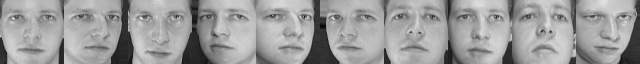

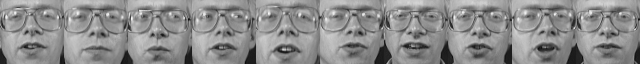

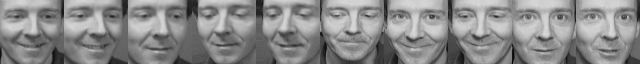

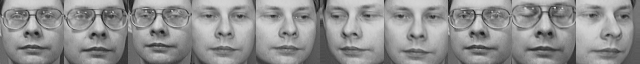

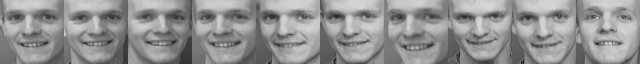

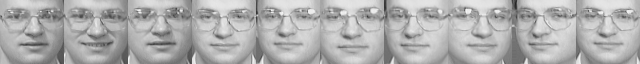

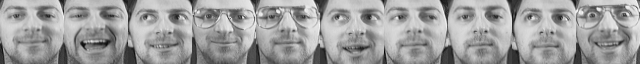

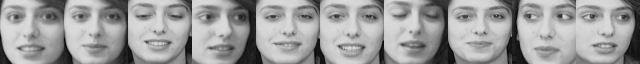

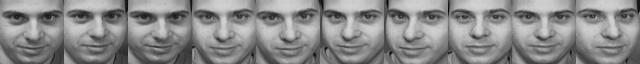

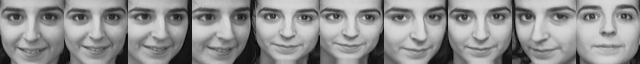

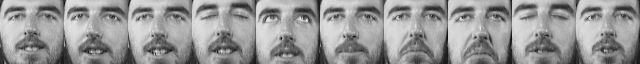

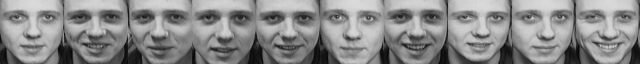

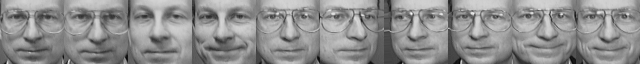

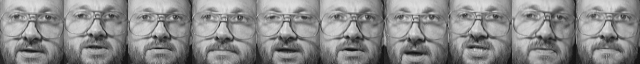

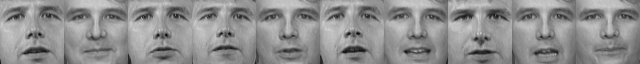

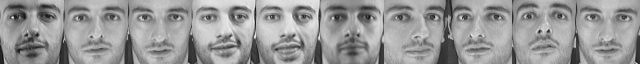

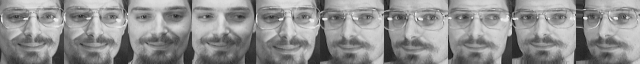

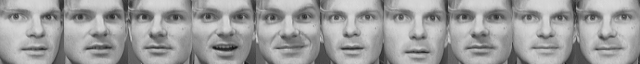

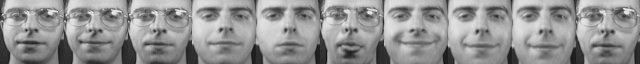

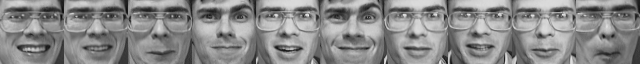

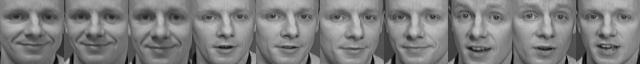

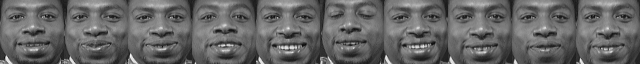

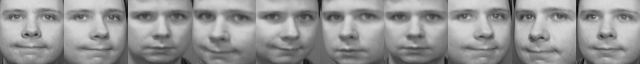

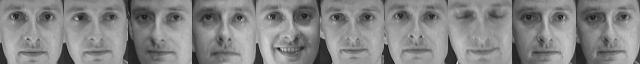

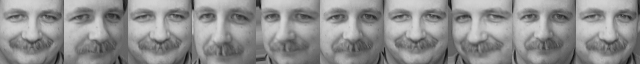

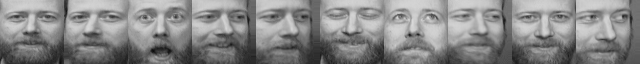

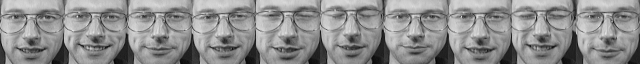

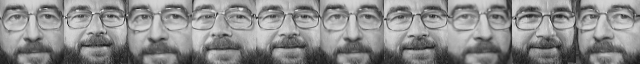

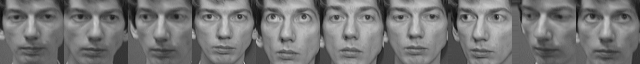

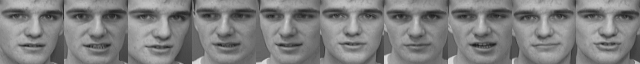

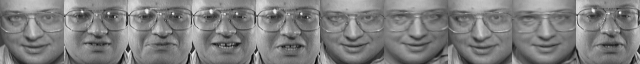

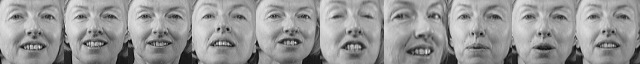

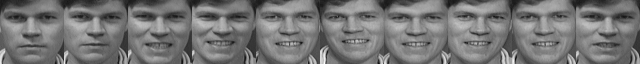

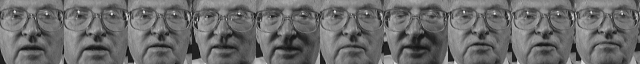

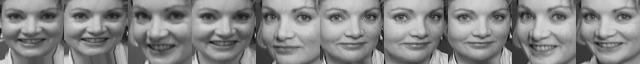

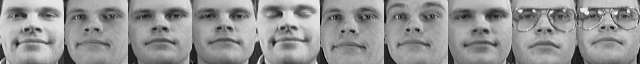

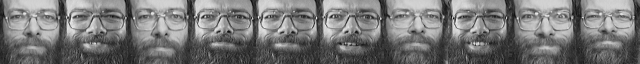

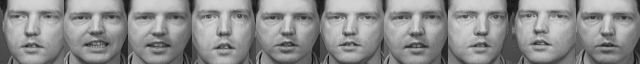

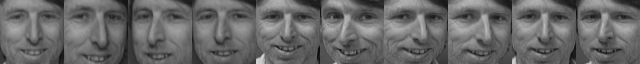

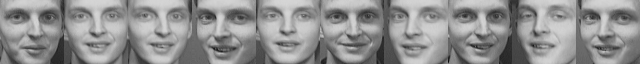

In [ ]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j]
      else:
        row = np.concatenate((row, imgs[i*num_cols+j]), axis=1)
    cv2_imshow(row * 255)

show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

# Split the Dataset for CNN:

In [ ]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset

# use the first GALLERY_SIZE images per individual for training, the rest for testing
#changing the gallery size changes the testing / training percentage
GALLERY_SIZE_1 = 2
GALLERY_SIZE_2 = 5
GALLERY_SIZE_3 = 8                         

"""I know this could probably be done in a more elegant way without repeating code, but to minimize
complications with the function calls and since there are only 3 separate scenarios, I decided
to do it this way."""

gallery_indices_1 = []
probe_indices_1 = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices_1 += indices[:GALLERY_SIZE_1]
  probe_indices_1 += indices[GALLERY_SIZE_1:]

gallery_indices_2 = []
probe_indices_2 = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices_2 += indices[:GALLERY_SIZE_2]
  probe_indices_2 += indices[GALLERY_SIZE_2:]

gallery_indices_3 = []
probe_indices_3 = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices_3 += indices[:GALLERY_SIZE_3]
  probe_indices_3 += indices[GALLERY_SIZE_3:]


x_train_1 = faces.images[gallery_indices_1].reshape(-1, img_height, img_width, 1) # vectorize train images
y_train_1 = faces.target[gallery_indices_1]
x_test_1 = faces.images[probe_indices_1].reshape(-1, img_height, img_width, 1)    # vectorize test images
y_test_1 = faces.target[probe_indices_1]

x_train_2 = faces.images[gallery_indices_2].reshape(-1, img_height, img_width, 1) # vectorize train images
y_train_2 = faces.target[gallery_indices_2]
x_test_2 = faces.images[probe_indices_2].reshape(-1, img_height, img_width, 1)   # vectorize test images
y_test_2 = faces.target[probe_indices_2]

x_train_3 = faces.images[gallery_indices_3].reshape(-1, img_height, img_width, 1) # vectorize train images
y_train_3 = faces.target[gallery_indices_3]
x_test_3 = faces.images[probe_indices_3].reshape(-1, img_height, img_width, 1)    # vectorize test images
y_test_3 = faces.target[probe_indices_3]


print(x_train_1.shape, x_test_1.shape)
print(x_train_2.shape, x_test_2.shape)
print(x_train_3.shape, x_test_3.shape)

(80, 64, 64, 1) (320, 64, 64, 1)
(200, 64, 64, 1) (200, 64, 64, 1)
(320, 64, 64, 1) (80, 64, 64, 1)


#Data for Small CNN (LeNet-5):



##Scenario 1: Use 20% of the images for training and 80% for testing.

Visualization of Scenario 1 Shape:

In [ ]:
print("x_train_1: ", x_train_1.shape)
print("x_test_1: ",x_test_1.shape )
print("y_train_1: ", y_train_1.shape)
print("y_test_1: ", y_test_1.shape)


x_train_1:  (80, 64, 64, 1)
x_test_1:  (320, 64, 64, 1)
y_train_1:  (80,)
y_test_1:  (320,)


Shuffle:

In [ ]:
shuffle = np.random.permutation(len(x_train_1))

x_val_1 = x_train_1.take(shuffle[:40], axis=0)
y_val_1 = y_train_1.take(shuffle[:40], axis=0)

print(x_val_1.shape, y_val_1.shape)

(40, 64, 64, 1) (40,)


Model Parameters

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=40, activation = 'softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 120)               3

Training Parameters:

In [ ]:
learning_rate = 0.001 
loss_function = 'sparse_categorical_crossentropy'
batch_size = 32
num_epochs = 50

Training Loop:

Epoch 1/50
3/3 [==============================] - 3s 171ms/step - loss: 3.7272 - accuracy: 0.0000e+00 - val_loss: 3.6897 - val_accuracy: 0.0250
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 3.6897 - accuracy: 0.0250 - val_loss: 3.6842 - val_accuracy: 0.0250
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 3.6833 - accuracy: 0.0250 - val_loss: 3.6813 - val_accuracy: 0.0250
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 3.6797 - accuracy: 0.0250 - val_loss: 3.6761 - val_accuracy: 0.0250
Epoch 5/50
3/3 [==============================] - 0s 15ms/step - loss: 3.6750 - accuracy: 0.0375 - val_loss: 3.6692 - val_accuracy: 0.0250
Epoch 6/50
3/3 [==============================] - 0s 30ms/step - loss: 3.6656 - accuracy: 0.0375 - val_loss: 3.6562 - val_accuracy: 0.1750
Epoch 7/50
3/3 [==============================] - 0s 40ms/step - loss: 3.6526 - accuracy: 0.1625 - val_loss: 3.6401 - val_accuracy: 0.2250
Epoch 8/50
3/3 [======

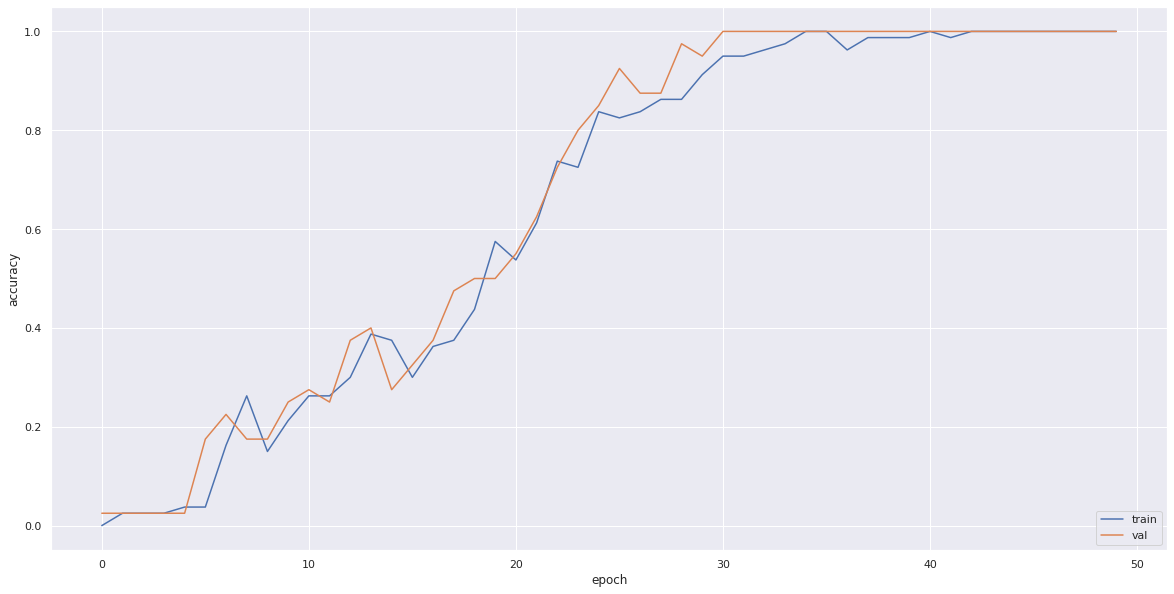

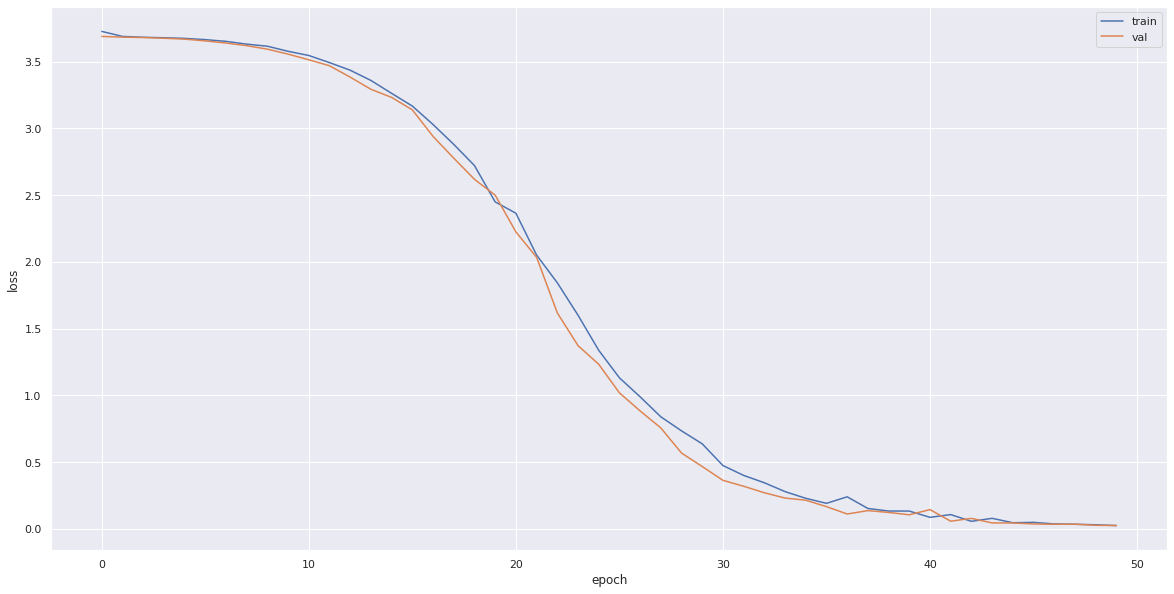

TRAINING SET
Loss: 0.3764662444591522 
Accuracy: 0.9624999761581421

VALIDATION SET
Loss: 0.36291325092315674 
Accuracy: 1.0

TEST SET
Loss: 1.4981240034103394 
Accuracy: 0.6312500238418579


In [ ]:
# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=0)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
history = model.fit(x=x_train_1,y=y_train_1, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val_1, y_val_1), callbacks=[early_stop, model_save])

plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train_1, y_train_1, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val_1, y_val_1, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test_1, y_test_1, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Confusion Matrix for Scenario 1:

10/10 [==============================] - 0s 3ms/step
Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       1.00      1.00      1.00         8
           2       1.00      0.25      0.40         8
           3       0.38      0.38      0.38         8
           4       0.50      0.62      0.56         8
           5       0.67      0.50      0.57         8
           6       0.80      0.50      0.62         8
           7       0.43      0.75      0.55         8
           8       0.55      0.75      0.63         8
           9       0.30      1.00      0.46         8
          10       1.00      0.75      0.86         8
          11       1.00      0.12      0.22         8
          12       1.00      0.25      0.40         8
          13       1.00      0.88      0.93         8
          14       0.54      0.88      0.67         8
          15       0.36      0.62      0.45         8
          1

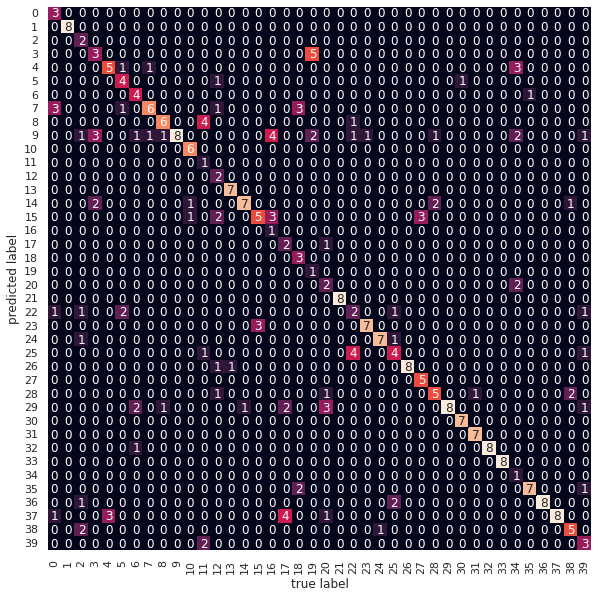

In [ ]:
Y_pred = model.predict(x_test_1)
yfit = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
mat = confusion_matrix(y_test_1, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_1, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_1.shape[0], (y_test_1 != yfit).sum()))

##Scenario 2: Use 50% of the images for training and 50% for testing.

Visualization of Scenario 2 Shape:

In [ ]:
print("x_train_2: ", x_train_2.shape)
print("x_test_2: ",x_test_2.shape )
print("y_train_2: ", y_train_2.shape)
print("y_test_2: ", y_test_2.shape)

x_train_2:  (200, 64, 64, 1)
x_test_2:  (200, 64, 64, 1)
y_train_2:  (200,)
y_test_2:  (200,)


Shuffle:

In [ ]:
shuffle = np.random.permutation(len(x_train_2))

x_val_2 = x_train_2.take(shuffle[:100], axis=0)
y_val_2 = y_train_2.take(shuffle[:100], axis=0)

print(x_val_2.shape, y_val_2.shape)

(100, 64, 64, 1) (100,)


Model Parameters:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=40, activation = 'softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2704)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

Training Parameters:

In [ ]:
learning_rate = 0.001
loss_function = 'sparse_categorical_crossentropy'
batch_size = 32
num_epochs = 50

Training Loop:

Epoch 1/50
7/7 [==============================] - 1s 53ms/step - loss: 3.7370 - accuracy: 0.0000e+00 - val_loss: 3.7018 - val_accuracy: 0.0200
Epoch 2/50
7/7 [==============================] - 0s 16ms/step - loss: 3.6881 - accuracy: 0.0300 - val_loss: 3.6841 - val_accuracy: 0.0400
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 3.6834 - accuracy: 0.0600 - val_loss: 3.6788 - val_accuracy: 0.1000
Epoch 4/50
7/7 [==============================] - 0s 9ms/step - loss: 3.6752 - accuracy: 0.0800 - val_loss: 3.6567 - val_accuracy: 0.0600
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 3.6596 - accuracy: 0.0500 - val_loss: 3.6236 - val_accuracy: 0.0600
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 3.6209 - accuracy: 0.0800 - val_loss: 3.5700 - val_accuracy: 0.2100
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 3.5703 - accuracy: 0.1300 - val_loss: 3.4951 - val_accuracy: 0.1400
Epoch 8/50
7/7 [=========

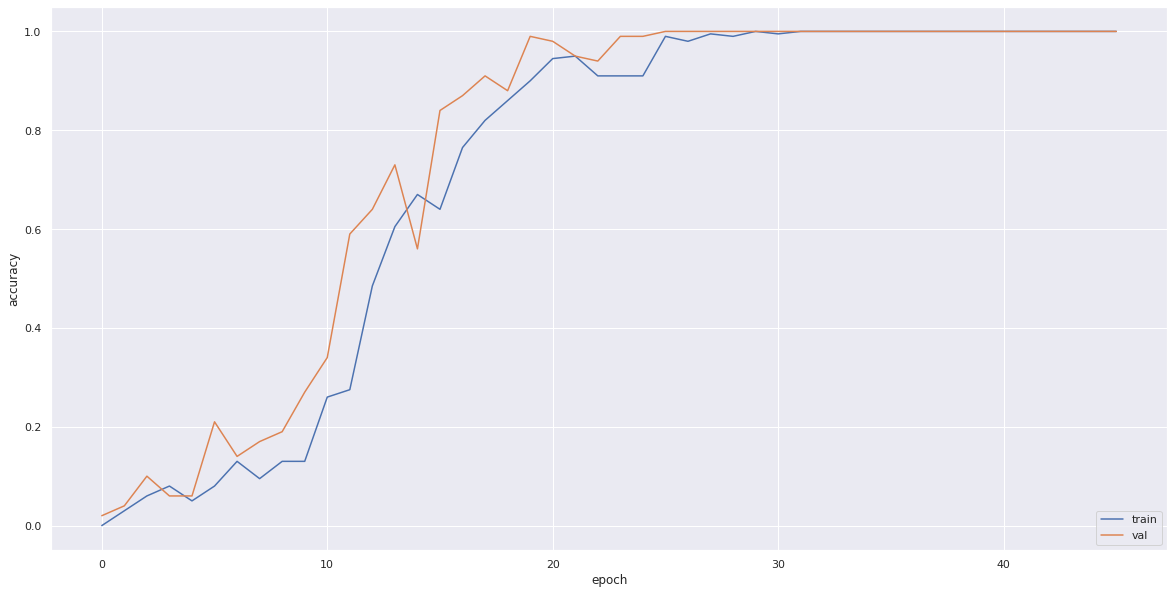

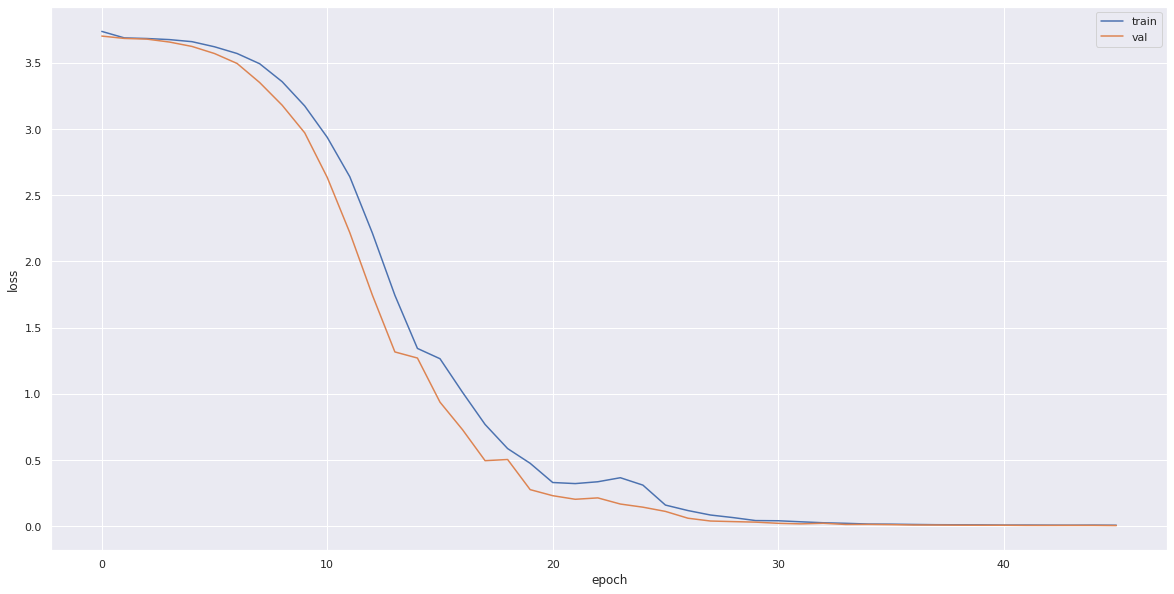

TRAINING SET
Loss: 0.12420015037059784 
Accuracy: 0.9900000095367432

VALIDATION SET
Loss: 0.11309142410755157 
Accuracy: 1.0

TEST SET
Loss: 0.9276912212371826 
Accuracy: 0.7950000166893005


In [ ]:
# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=0)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
history = model.fit(x=x_train_2,y=y_train_2, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val_2, y_val_2), callbacks=[early_stop, model_save])

plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train_2, y_train_2, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val_2, y_val_2, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test_2, y_test_2, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Confusion Matrix for Scenario 2:

7/7 [==============================] - 0s 3ms/step
Confusion Matrix
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.83      1.00      0.91         5
           2       0.67      0.40      0.50         5
           3       1.00      0.40      0.57         5
           4       0.67      0.80      0.73         5
           5       0.36      1.00      0.53         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      0.60      0.75         5
           9       1.00      0.60      0.75         5
          10       0.56      1.00      0.71         5
          11       1.00      0.80      0.89         5
          12       0.67      0.40      0.50         5
          13       0.71      1.00      0.83         5
          14       0.62      1.00      0.77         5
          15       0.67      0.80      0.73         5
          16 

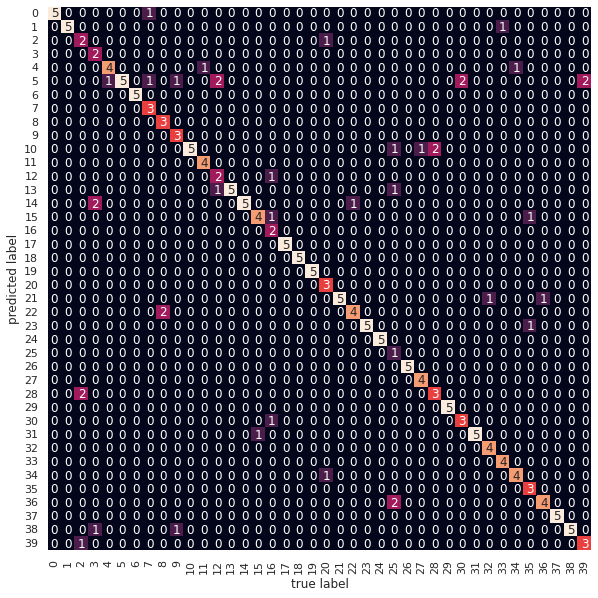

In [ ]:
Y_pred = model.predict(x_test_2)
yfit = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
mat = confusion_matrix(y_test_2, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_2, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_2.shape[0], (y_test_2 != yfit).sum()))

##Scenario 3: Use 80% of the images for training and 20% for testing.

Visualization of Scenario 3 Shape:

In [ ]:
print("x_train_3: ", x_train_3.shape)
print("x_test_3: ",x_test_3.shape )
print(x_train_3.shape, y_train_3.shape, x_train_3.dtype, y_train_3.dtype)
print(x_test_3.shape, y_test_3.shape)

x_train_3:  (320, 64, 64, 1)
x_test_3:  (80, 64, 64, 1)
(320, 64, 64, 1) (320,) float32 int64
(80, 64, 64, 1) (80,)


Shuffle:

In [ ]:
shuffle = np.random.permutation(len(x_train_3))

x_val_3 = x_train_3.take(shuffle[:160], axis=0)
y_val_3 = y_train_3.take(shuffle[:160], axis=0)

print(x_val_3.shape, y_val_3.shape)

(160, 64, 64, 1) (160,)


Model Parameters:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dense(units=40, activation = 'softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2704)              0         
                                                                 
 dense_6 (Dense)             (None, 120)              

Training Parameters:

In [ ]:
learning_rate = 0.001
loss_function = 'sparse_categorical_crossentropy'
batch_size = 32
num_epochs = 50

Training Loop:

Epoch 1/50
10/10 [==============================] - 1s 27ms/step - loss: 3.7005 - accuracy: 0.0281 - val_loss: 3.6877 - val_accuracy: 0.0063
Epoch 2/50
10/10 [==============================] - 0s 10ms/step - loss: 3.6889 - accuracy: 0.0188 - val_loss: 3.6883 - val_accuracy: 0.0188
Epoch 3/50
10/10 [==============================] - 0s 11ms/step - loss: 3.6868 - accuracy: 0.0469 - val_loss: 3.6806 - val_accuracy: 0.0312
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 3.6702 - accuracy: 0.0594 - val_loss: 3.6556 - val_accuracy: 0.0125
Epoch 5/50
10/10 [==============================] - 0s 11ms/step - loss: 3.6379 - accuracy: 0.0750 - val_loss: 3.5923 - val_accuracy: 0.0938
Epoch 6/50
10/10 [==============================] - 0s 10ms/step - loss: 3.5414 - accuracy: 0.1500 - val_loss: 3.4389 - val_accuracy: 0.1312
Epoch 7/50
10/10 [==============================] - 0s 12ms/step - loss: 3.3594 - accuracy: 0.2031 - val_loss: 3.1565 - val_accuracy: 0.3000
Epoch 8/50
10/

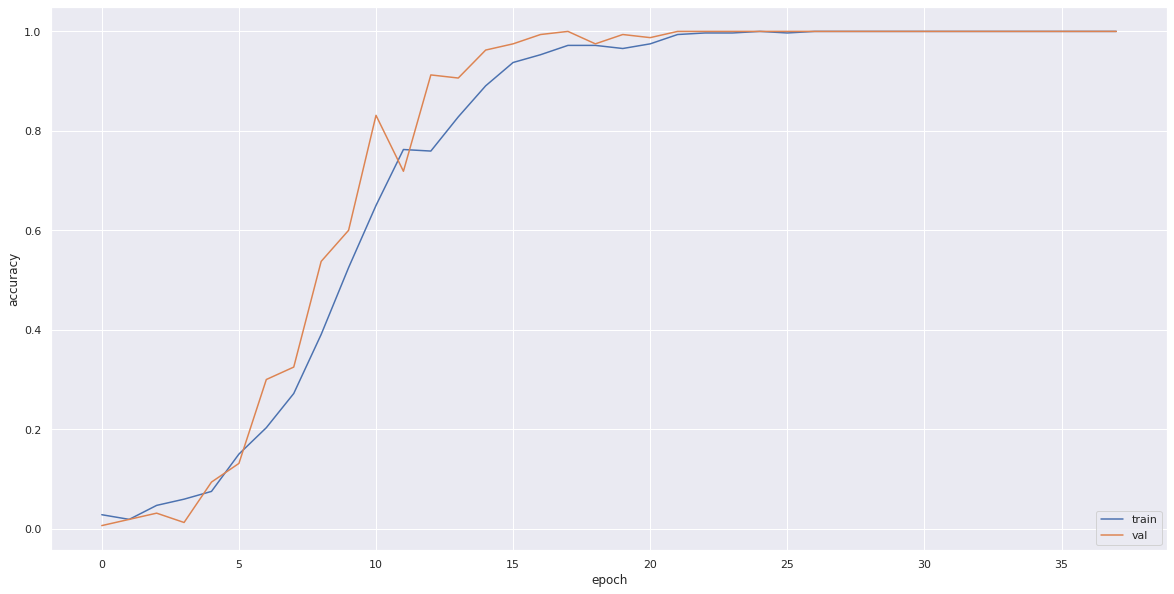

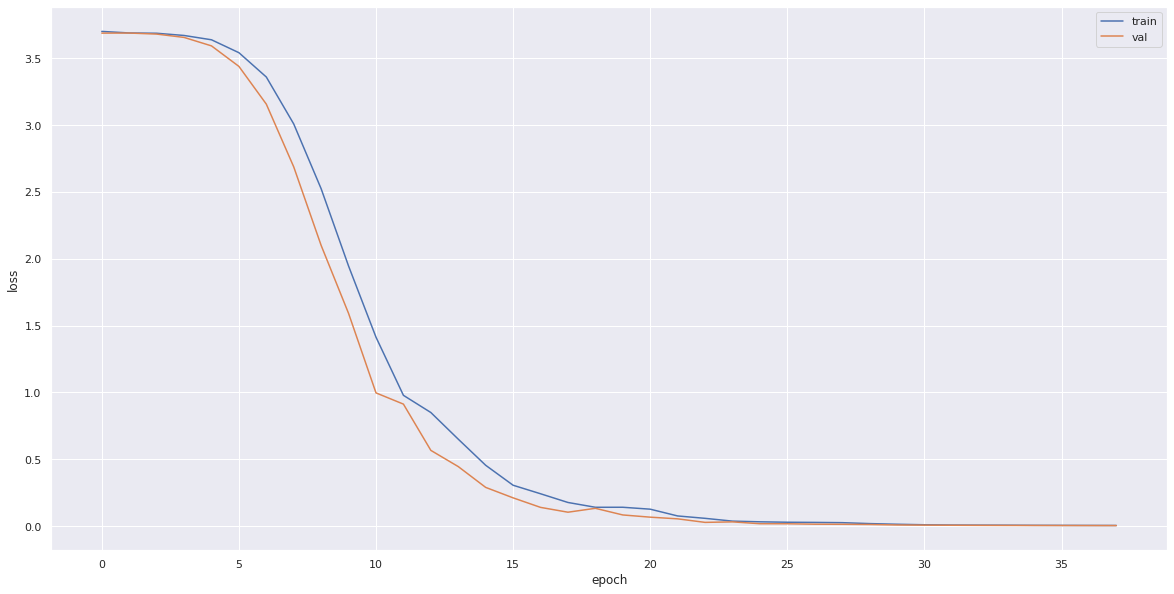

TRAINING SET
Loss: 0.12340159714221954 
Accuracy: 0.9937499761581421

VALIDATION SET
Loss: 0.10412957519292831 
Accuracy: 1.0

TEST SET
Loss: 0.735595703125 
Accuracy: 0.8125


In [ ]:
# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=0)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
history = model.fit(x=x_train_3,y=y_train_3, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val_3, y_val_3), callbacks=[early_stop, model_save])

plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train_3, y_train_3, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val_3, y_val_3, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test_3, y_test_3, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Confusion Matrix for Scenario 3:

3/3 [==============================] - 0s 4ms/step
Confusion Matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       0.50      1.00      0.67         2
           6       1.00      1.00      1.00         2
           7       0.50      0.50      0.50         2
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.20      0.50      0.29         2
          13       1.00      1.00      1.00         2
          14       0.50      0.50      0.50         2
          15       1.00      0.50      0.67         2
          16       1.00      1.00      1.00         2
          17       1.00    

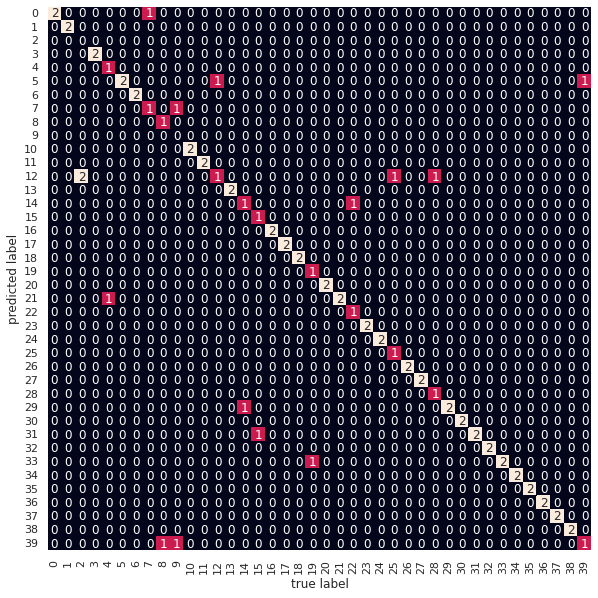

In [ ]:
Y_pred = model.predict(x_test_3)
yfit = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
mat = confusion_matrix(y_test_3, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_3, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_3.shape[0], (y_test_3 != yfit).sum()))

##Data Augmentation:
Using tf.keras.preprocessing.image.ImageDataGenerator


Epoch 1/50
13/13 [==============================] - 1s 43ms/step - loss: 3.9672 - accuracy: 0.2740 - val_loss: 1.4194 - val_accuracy: 0.7937
Epoch 2/50
13/13 [==============================] - 1s 39ms/step - loss: 2.9981 - accuracy: 0.2981 - val_loss: 1.6311 - val_accuracy: 0.8500
Epoch 3/50
13/13 [==============================] - 0s 32ms/step - loss: 2.8909 - accuracy: 0.3125 - val_loss: 1.1137 - val_accuracy: 0.8875
Epoch 4/50
13/13 [==============================] - 0s 29ms/step - loss: 2.5786 - accuracy: 0.3774 - val_loss: 0.7576 - val_accuracy: 0.9187
Epoch 5/50
13/13 [==============================] - 1s 38ms/step - loss: 2.3812 - accuracy: 0.4135 - val_loss: 0.7404 - val_accuracy: 0.9438
Epoch 6/50
13/13 [==============================] - 0s 29ms/step - loss: 2.3331 - accuracy: 0.4231 - val_loss: 0.6265 - val_accuracy: 0.9812
Epoch 7/50
13/13 [==============================] - 0s 32ms/step - loss: 1.9769 - accuracy: 0.5144 - val_loss: 0.4926 - val_accuracy: 0.9563
Epoch 8/50
13

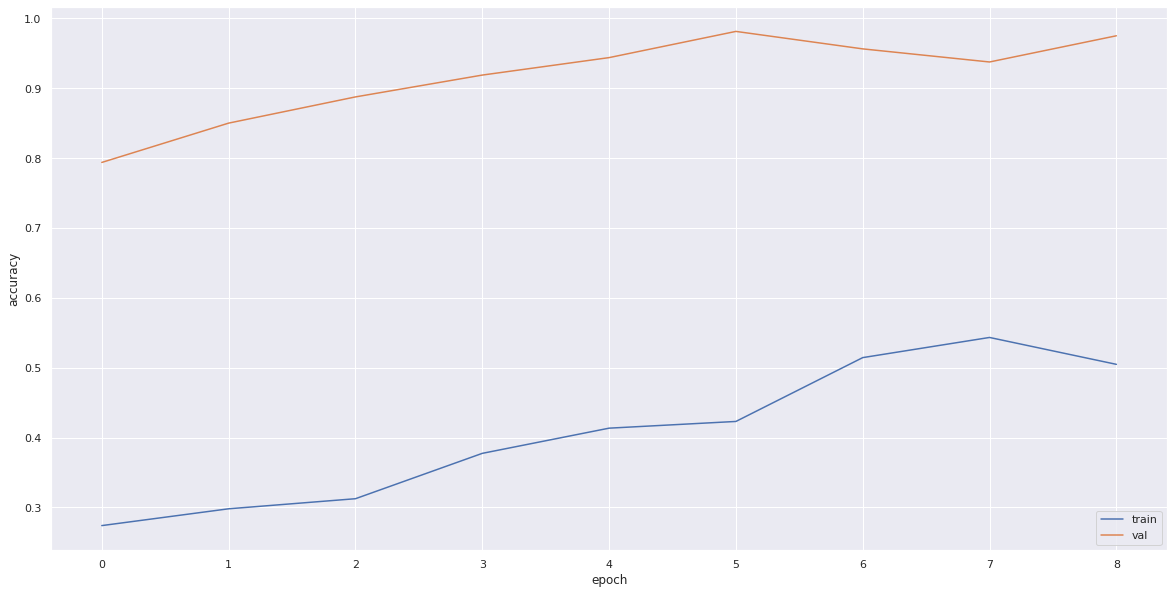

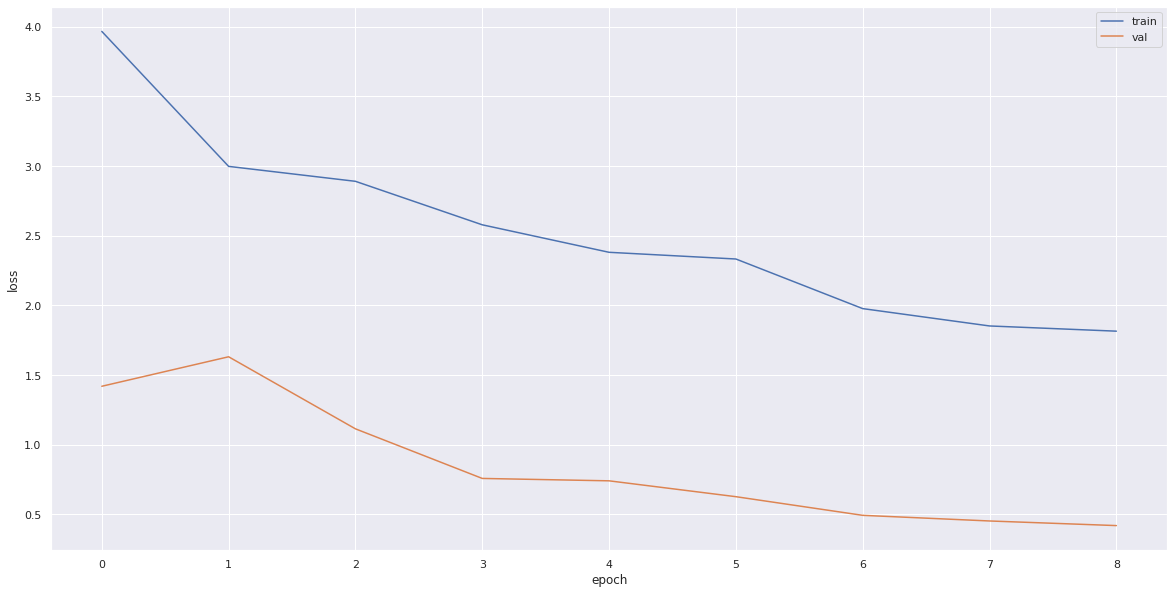

TRAINING SET
Loss: 0.6278145909309387 
Accuracy: 0.9624999761581421

VALIDATION SET
Loss: 0.6265297532081604 
Accuracy: 0.981249988079071

TEST SET
Loss: 1.0208189487457275 
Accuracy: 0.8125


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  featurewise_center = False,            # set input mean to 0 over the dataset
  samplewise_center = False,             # set each sample mean to 0
  featurewise_std_normalization = False, # divide inputs by std of the dataset
  samplewise_std_normalization = False,  # divide each input by its std
  zca_whitening = False,                 # apply ZCA whitening
  zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
  rotation_range = 5,                    # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
  height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
  shear_range = 0.,                      # set range for random shear
  zoom_range = 0.1,                      # set range for random zoom
  channel_shift_range = 0.,              # set range for random channel shifts
  fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
  cval = 0.,                             # value used for fill_mode = "constant"
  horizontal_flip = False,               # randomly flip images
  vertical_flip = False,                 # randomly flip images
  rescale = None,                        # set rescaling factor (applied before any other transformation)
  preprocessing_function = None,         # set function that will be applied on each input
  data_format = None,                    # image data format, either "channels_first" or "channels_last"
  validation_split = 0.0                 # fraction of images reserved for validation (strictly between 0 and 1)
)
datagen.fit(x_train_3)

# training configuration
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

#train
steps_for_epoch = np.ceil(x_train.shape[0] / batch_size)
history = model.fit(datagen.flow(x_train_3, y_train_3, batch_size=batch_size), steps_per_epoch = steps_for_epoch, epochs=num_epochs, validation_data=(x_val_3, y_val_3), workers=4, callbacks=[early_stop, model_save])


plt.rcParams["figure.figsize"] = (20,10)

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train_3, y_train_3, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val_3, y_val_3, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test_3, y_test_3, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Confusion Matrix:

3/3 [==============================] - 0s 3ms/step
Confusion Matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         2
           3       0.50      0.50      0.50         2
           4       1.00      0.50      0.67         2
           5       0.50      1.00      0.67         2
           6       1.00      0.50      0.67         2
           7       1.00      0.50      0.67         2
           8       1.00      0.50      0.67         2
           9       0.33      0.50      0.40         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       0.50      0.50      0.50         2
          15       0.00      0.00      0.00         2
          16       1.00      1.00      1.00         2
          17       0.50    

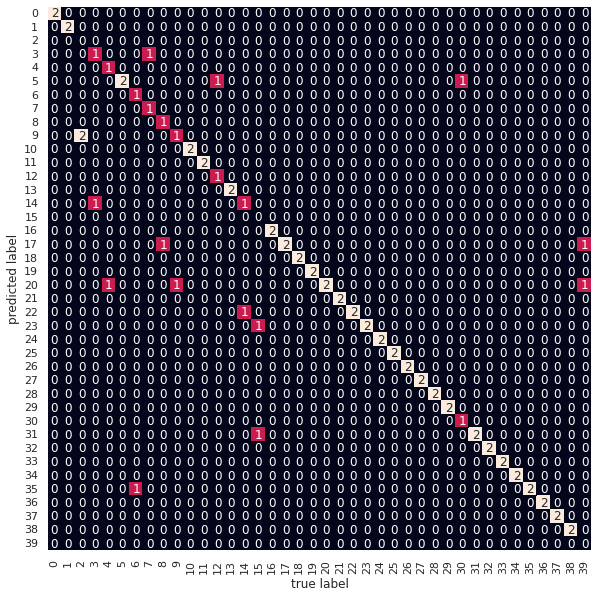

In [ ]:
Y_pred = model.predict(x_test_3)
yfit = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
mat = confusion_matrix(y_test_3, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_3, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_3.shape[0], (y_test_3 != yfit).sum()))

Augmentation made no difference in accuracy of the data.

#Re-Split the Dataset for PCA/LDA/SVM:

In [ ]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset

# use the first GALLERY_SIZE images per individual for training, the rest for testing
#changing the gallery size changes the testing / training percentage
GALLERY_SIZE_1 = 2
GALLERY_SIZE_2 = 5
GALLERY_SIZE_3 = 8                         

"""I know this could probably be done in a more elegant way without repeating code, but to minimize
complications with the function calls and since there are only 3 separate scenarios, I decided
to do it this way."""

gallery_indices_1 = []
probe_indices_1 = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices_1 += indices[:GALLERY_SIZE_1]
  probe_indices_1 += indices[GALLERY_SIZE_1:]

gallery_indices_2 = []
probe_indices_2 = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices_2 += indices[:GALLERY_SIZE_2]
  probe_indices_2 += indices[GALLERY_SIZE_2:]

gallery_indices_3 = []
probe_indices_3 = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices_3 += indices[:GALLERY_SIZE_3]
  probe_indices_3 += indices[GALLERY_SIZE_3:]


x_train_1 = faces.images[gallery_indices_1].reshape(-1, img_height*img_width) # vectorize train images
y_train_1 = faces.target[gallery_indices_1]
x_test_1 = faces.images[probe_indices_1].reshape(-1, img_height*img_width)    # vectorize test images
y_test_1 = faces.target[probe_indices_1]

x_train_2 = faces.images[gallery_indices_2].reshape(-1, img_height*img_width) # vectorize train images
y_train_2 = faces.target[gallery_indices_2]
x_test_2 = faces.images[probe_indices_2].reshape(-1, img_height*img_width)    # vectorize test images
y_test_2 = faces.target[probe_indices_2]

x_train_3 = faces.images[gallery_indices_3].reshape(-1, img_height*img_width) # vectorize train images
y_train_3 = faces.target[gallery_indices_3]
x_test_3 = faces.images[probe_indices_3].reshape(-1, img_height*img_width)    # vectorize test images
y_test_3 = faces.target[probe_indices_3]


print(x_train_1.shape, x_test_1.shape)
print(x_train_2.shape, x_test_2.shape)
print(x_train_3.shape, x_test_3.shape)



(80, 4096) (320, 4096)
(200, 4096) (200, 4096)
(320, 4096) (80, 4096)


# Data for PCA:

##Scenario 1: Use 20% of the images for training and 80% for testing.

Visualization of evaluation scenario 1: Use 20% of the images for training and 80% for testing.


Image Height * Width:  4096
Training Shape:  (80, 4096)
Testing Shape:  (320, 4096)
Projected Shape:  (80, 2)
Variance Ratio:  [0.24381226 0.10267446]
Average Image: 


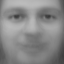

In [ ]:
pca = PCA(n_components=2)
projected = pca.fit_transform(x_train_1.reshape(-1, img_height*img_width))
print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_1.shape)
print("Testing Shape: ", x_test_1.shape)
print("Projected Shape: ", projected.shape)

print("Variance Ratio: ", pca.explained_variance_ratio_)
print("Average Image: ")
cv2_imshow(pca.mean_.reshape(img_height, img_width) * 255)

PCA CMC Curve - Scenario 1 (20 / 80 Split):

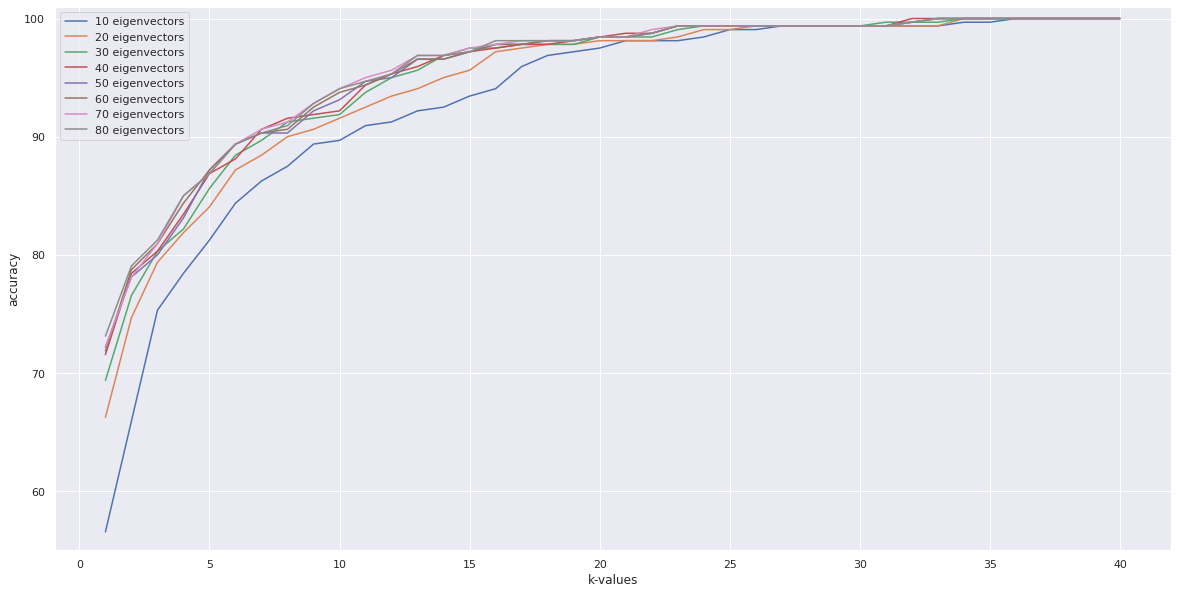

In [ ]:
for i in range(10,90,10):
  pca = PCA(n_components=i)
  pca.fit(x_train_1.reshape(-1, img_height*img_width))

  gallery = pca.transform(x_train_1.reshape(-1, img_height*img_width))
  probe = pca.transform(x_test_1.reshape(-1, img_height*img_width))

  CMC = {}
  for j in range(len(probe)):
    genuine_dist = np.inf
    for k in range(len(gallery)):
      if y_test_1[j] == y_train_1[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          genuine_dist = dist
    ids = set()
    for k in range(len(gallery)):
      if y_test_1[j] != y_train_1[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          ids.add(y_train_1[k])
    rank=1+len(ids)
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  rank = []
  acc = []
  total = 0
  for j in range(1, N_IDENTITIES+1):
    if j in CMC:
      total += CMC[j]
    rank.append(j)
    acc.append(100.0*total/len(probe))

  plt.plot(rank, acc, label=str(i)+' eigenvectors')
  plt.legend()
  plt.xlabel('k-values')
  plt.ylabel('accuracy')
  plt.ylim(55, 101)
  plt.plot()

At 45 components, accuracy becomes indistinguishable from higher components. We use this number for our component factor in the confusion matrix.

PCA Confusion Matrix - Scenario 1 (20/80 Split):

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       1.00      1.00      1.00         8
           2       0.20      0.12      0.15         8
           3       1.00      0.38      0.55         8
           4       1.00      0.75      0.86         8
           5       1.00      1.00      1.00         8
           6       0.83      0.62      0.71         8
           7       1.00      0.25      0.40         8
           8       0.62      0.62      0.62         8
           9       1.00      0.25      0.40         8
          10       0.67      1.00      0.80         8
          11       0.86      0.75      0.80         8
          12       1.00      0.50      0.67         8
          13       1.00      1.00      1.00         8
          14       0.42      1.00      0.59         8
          15       1.00      0.88      0.93         8
          16       1.00      0.25      0.40         8
          17       0.73    

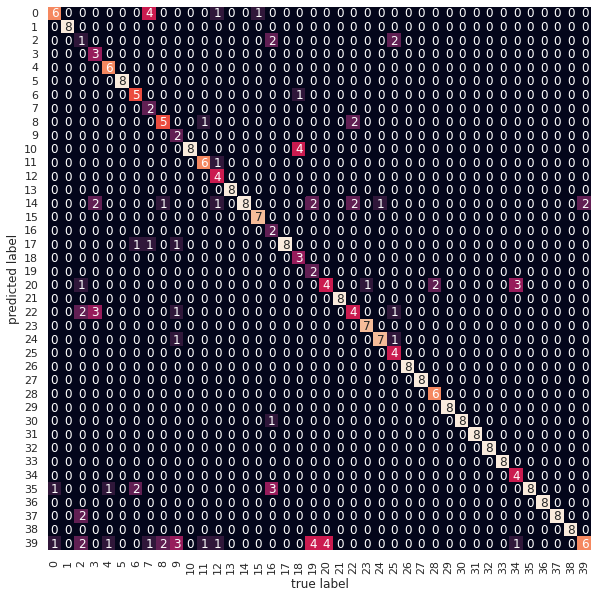

In [ ]:
#pick n based on the plot
#describe why logistic regression
pca = PCA(n_components=45)
pca.fit(x_train_1.reshape(-1, img_height*img_width))

gallery = pca.transform(x_train_1.reshape(-1, img_height*img_width))
probe = pca.transform(x_test_1.reshape(-1, img_height*img_width))

logr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logr.fit(gallery, y_train_1)
yfit = logr.predict(probe)

mat = confusion_matrix(y_test_1, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_1, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_1.shape[0], (y_test_1 != yfit).sum()))


Scenario 1 has an accuracy of 75%, doing fairly well overall but struggling on the middle and later images.

##Scenario 2: Use 50% of the images for training and 50% for testing.

Visualization of evaluation scenario 2: Use 50% of the images for training and 50% for testing.

Image Height * Width:  4096
Training Shape:  (200, 4096)
Testing Shape:  (200, 4096)
Projected Shape:  (200, 2)
Variance Ratio:  [0.23886332 0.11682399]
Average Image: 


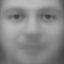

In [ ]:
pca = PCA(n_components=2)
projected = pca.fit_transform(x_train_2.reshape(-1, img_height*img_width))
print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_2.shape)
print("Testing Shape: ", x_test_2.shape)
print("Projected Shape: ", projected.shape)

print("Variance Ratio: ", pca.explained_variance_ratio_)
print("Average Image: ")
cv2_imshow(pca.mean_.reshape(img_height, img_width) * 255)

PCA CMC Curve - Scenario 2 (50 / 50 Split):

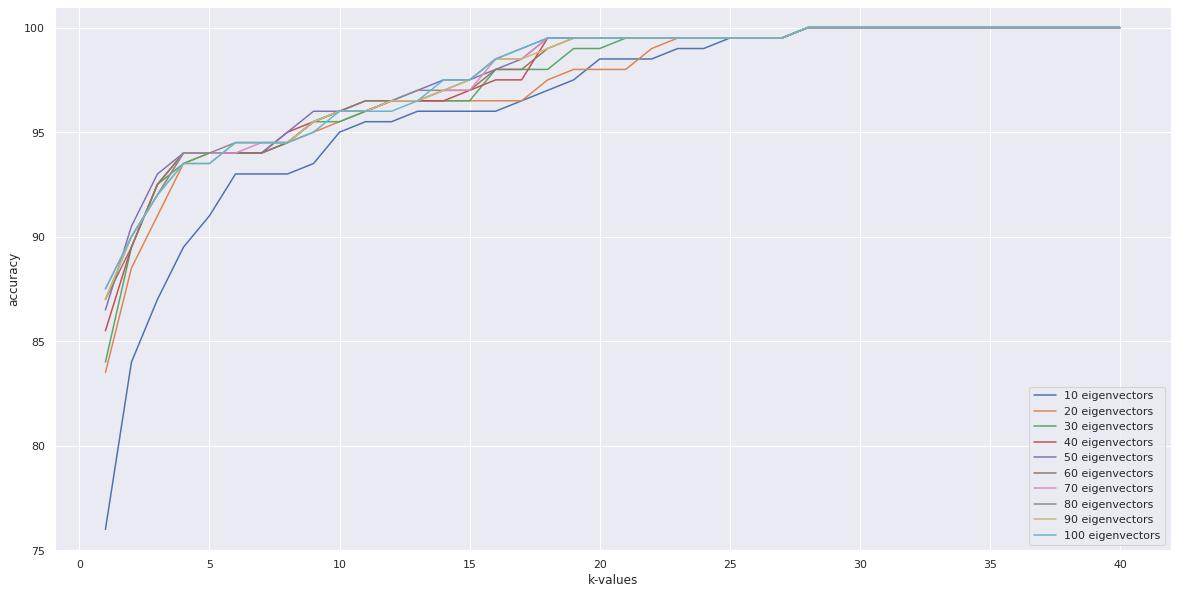

In [ ]:
for i in range(10,101,10):
  pca = PCA(n_components=i)
  pca.fit(x_train_2.reshape(-1, img_height*img_width))

  gallery = pca.transform(x_train_2.reshape(-1, img_height*img_width))
  probe = pca.transform(x_test_2.reshape(-1, img_height*img_width))

  CMC = {}
  for j in range(len(probe)):
    genuine_dist = np.inf
    for k in range(len(gallery)):
      if y_test_2[j] == y_train_2[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          genuine_dist = dist
    ids = set()
    for k in range(len(gallery)):
      if y_test_2[j] != y_train_2[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          ids.add(y_train_2[k])
    rank=1+len(ids)
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  rank = []
  acc = []
  total = 0
  for j in range(1, N_IDENTITIES+1):
    if j in CMC:
      total += CMC[j]
    rank.append(j)
    acc.append(100.0*total/len(probe))

  plt.plot(rank, acc, label=str(i)+' eigenvectors')
  plt.legend()
  plt.xlabel('k-values')
  plt.ylabel('accuracy')
  plt.ylim(75, 101)
  plt.plot()

Again, around 45 components accuracy becomes indistinguishable from higher components. We use this number for our component factor in the confusion matrix.

PCA Confusion Matrix - Scenario 2 (50/50 Split):

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      0.60      0.75         5
          12       0.33      0.40      0.36         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89         5
          16       1.00      0.20      0.33         5
          17       1.00    

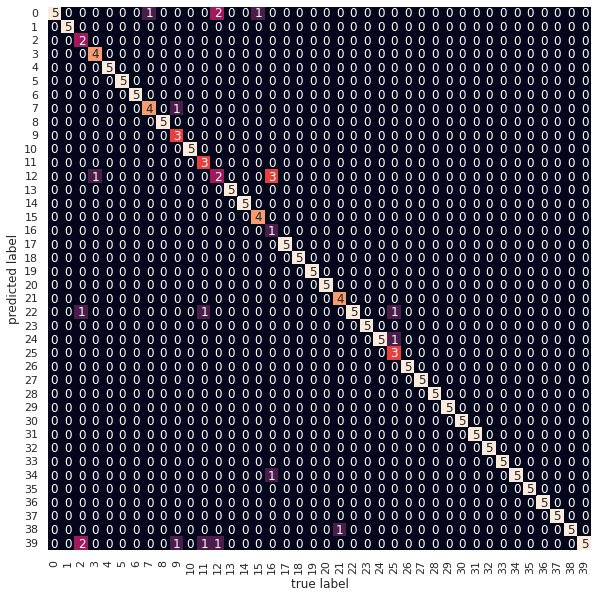

In [ ]:
pca = PCA(n_components=45)
pca.fit(x_train_2.reshape(-1, img_height*img_width))

gallery = pca.transform(x_train_2.reshape(-1, img_height*img_width))
probe = pca.transform(x_test_2.reshape(-1, img_height*img_width))

logr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logr.fit(gallery, y_train_2)
yfit = logr.predict(probe)

mat = confusion_matrix(y_test_2, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_2, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_2.shape[0], (y_test_2 != yfit).sum()))


Scenario 2 boasts an accuraccy of 90%, much higher than Scenario 1's 75%. The model struggles a bit towards the last image and some middle images.

##Scenario 3: Use 80% of the images for training and 20% for testing.

Visualization of evaluation scenario 3: Use 80% of the images for training and 20% for testing.



Image Height * Width:  4096
Training Shape:  (320, 4096)
Testing Shape:  (80, 4096)
Projected Shape:  (320, 2)
Variance Ratio:  [0.23653702 0.12971407]
Average Image: 


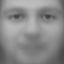

In [ ]:
pca = PCA(n_components=2)
projected = pca.fit_transform(x_train_3.reshape(-1, img_height*img_width))
print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_3.shape)
print("Testing Shape: ", x_test_3.shape)
print("Projected Shape: ", projected.shape)

print("Variance Ratio: ", pca.explained_variance_ratio_)
print("Average Image: ")
cv2_imshow(pca.mean_.reshape(img_height, img_width) * 255)

PCA CMC Curve - Scenario 3 (80 / 20 Split):

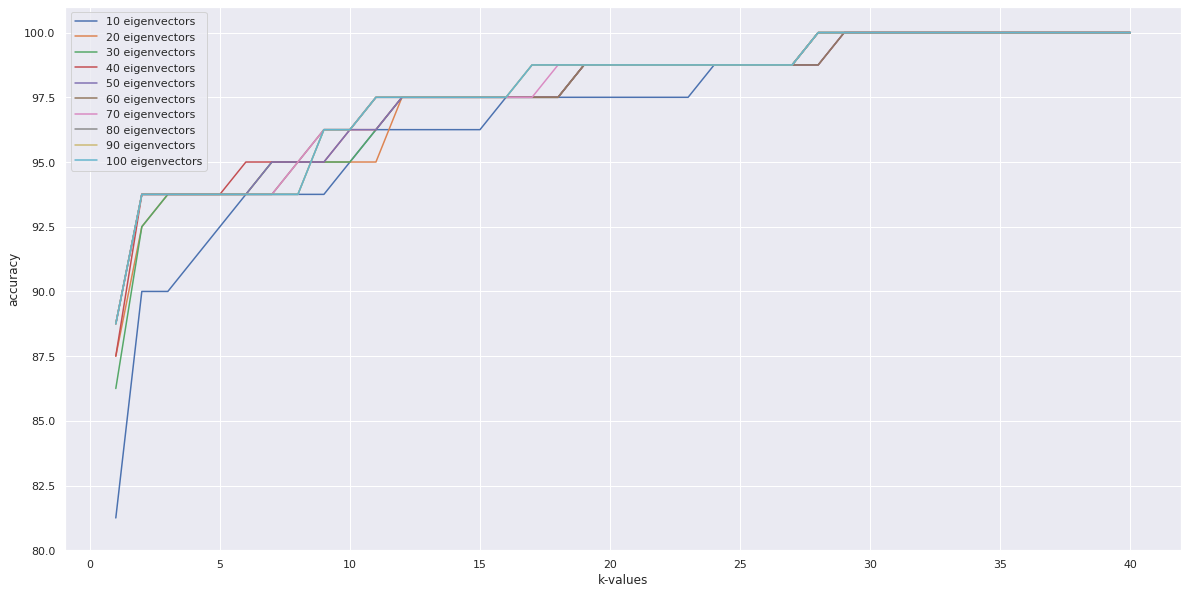

In [ ]:
for i in range(10,101,10):
  pca = PCA(n_components=i)
  pca.fit(x_train_3.reshape(-1, img_height*img_width))

  gallery = pca.transform(x_train_3.reshape(-1, img_height*img_width))
  probe = pca.transform(x_test_3.reshape(-1, img_height*img_width))

  CMC = {}
  for j in range(len(probe)):
    genuine_dist = np.inf
    for k in range(len(gallery)):
      if y_test_3[j] == y_train_3[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          genuine_dist = dist
    ids = set()
    for k in range(len(gallery)):
      if y_test_3[j] != y_train_3[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          ids.add(y_train_3[k])
    rank=1+len(ids)
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  rank = []
  acc = []
  total = 0
  for j in range(1, N_IDENTITIES+1):
    if j in CMC:
      total += CMC[j]
    rank.append(j)
    acc.append(100.0*total/len(probe))

  plt.plot(rank, acc, label=str(i)+' eigenvectors')
  plt.legend()
  plt.xlabel('k-values')
  plt.ylabel('accuracy')
  plt.ylim(80, 101)
  plt.plot()

Similar to the first two scenarios, 45 is an accurate enough amount of components for evaluation of the dataset.

PCA CMC Curve - Scenario 3 (80 / 20 Split):

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

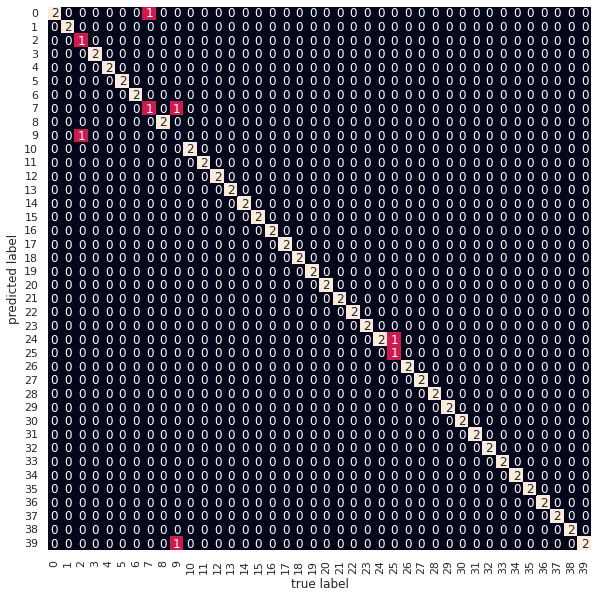

In [ ]:
pca = PCA(n_components=45)
pca.fit(x_train_3.reshape(-1, img_height*img_width))

gallery = pca.transform(x_train_3.reshape(-1, img_height*img_width))
probe = pca.transform(x_test_3.reshape(-1, img_height*img_width))

logr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logr.fit(gallery, y_train_3)
yfit = logr.predict(probe)

mat = confusion_matrix(y_test_3, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_3, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_3.shape[0], (y_test_3 != yfit).sum()))

Scenario 3 has the highest accuract among PCA at 94%.

#Data for LDA:


##Scenario 1: Use 20% of the images for training and 80% for testing.


Visualization of evaluation scenario 1: Use 20% of the images for training and 80% for testing.

Image Height * Width:  4096
Training Shape:  (80, 4096)
Testing Shape:  (320, 4096)
Projected Shape:  (80, 2)
Variance Ratio:  [0.23079823 0.21020805]
Average Image: 


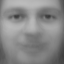

In [ ]:
lda = LDA(n_components=2)
projected = lda.fit_transform(x_train_1.reshape(-1, img_height*img_width), y_train_1)

print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_1.shape)
print("Testing Shape: ", x_test_1.shape)
print("Projected Shape: ", projected.shape)

print("Variance Ratio: ", lda.explained_variance_ratio_)
print("Average Image: ")

cv2_imshow(lda.xbar_.reshape(img_height, img_width) * 255)

LDA CMC Curve - Scenario 1 (20 / 80 Split):

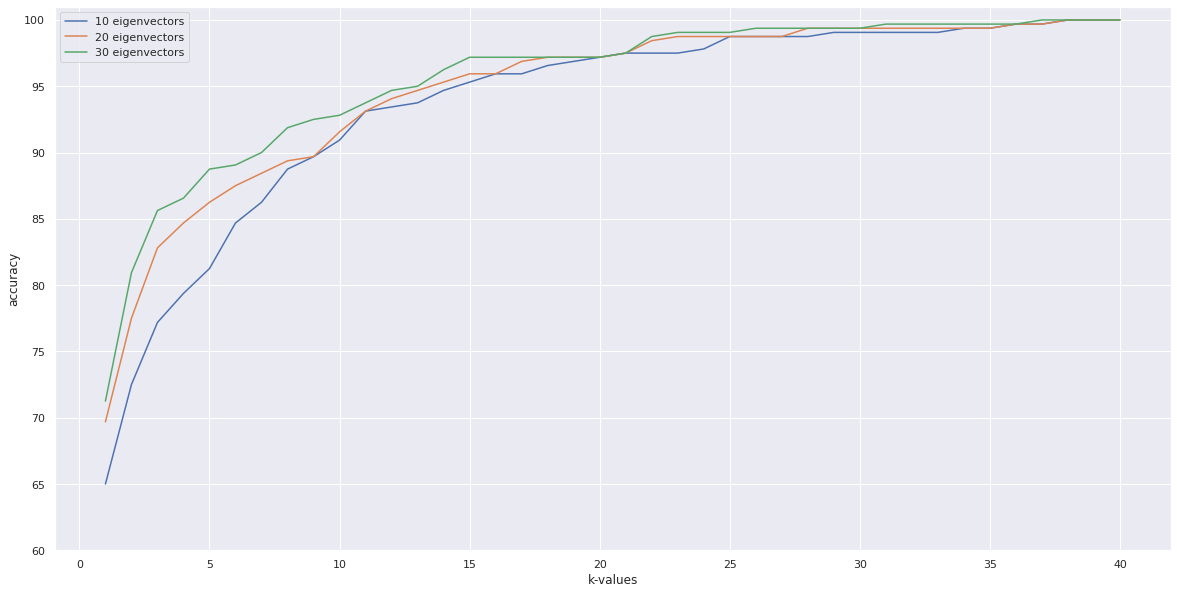

In [ ]:
# CMC plots for LDA
for i in range(10,40,10):
  lda = LDA(n_components=i)
  lda.fit(x_train_1.reshape(-1, img_height*img_width), y_train_1)

  gallery = lda.transform(x_train_1.reshape(-1, img_height*img_width))
  probe = lda.transform(x_test_1.reshape(-1, img_height*img_width))

  CMC = {}
  # For each test case...
  for j in range(len(probe)):
    # Compute the distance to closest correct label.
    genuine_dist = np.inf
    for k in range(len(gallery)):
      if y_test_1[j] == y_train_1[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          genuine_dist = dist
    # Compute number of incorrect labels closer than closest correct label.
    ids = set()
    for k in range(len(gallery)):
      if y_test_1[j] != y_train_1[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          ids.add(y_train_1[k])
    # Record rank of closest correct label.
    rank=1+len(ids)
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  rank = []
  acc = []
  total = 0
  for j in range(1, N_IDENTITIES+1):
    if j in CMC:
      total += CMC[j]
    rank.append(j)
    acc.append(100.0*total/len(probe))

  plt.plot(rank, acc, label=str(i)+' eigenvectors')
  plt.legend()
  plt.xlabel('k-values')
  plt.ylabel('accuracy')
  plt.ylim(60, 101)
  plt.plot()

Because LDA doesn't use as many components as PCA, we use as much as we can to study the data. This will be the same for the future LDA scenarios.

LDA Confusion Matrix - Scenario 1 (20/80 Split):

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       1.00      1.00      1.00         8
           2       0.50      0.12      0.20         8
           3       0.67      0.50      0.57         8
           4       1.00      0.62      0.77         8
           5       1.00      1.00      1.00         8
           6       0.75      0.38      0.50         8
           7       1.00      0.25      0.40         8
           8       0.67      0.75      0.71         8
           9       1.00      0.62      0.77         8
          10       0.64      0.88      0.74         8
          11       0.83      0.62      0.71         8
          12       0.67      0.50      0.57         8
          13       0.89      1.00      0.94         8
          14       0.62      1.00      0.76         8
          15       0.88      0.88      0.88         8
          16       0.67      0.50      0.57         8
          17       0.57    

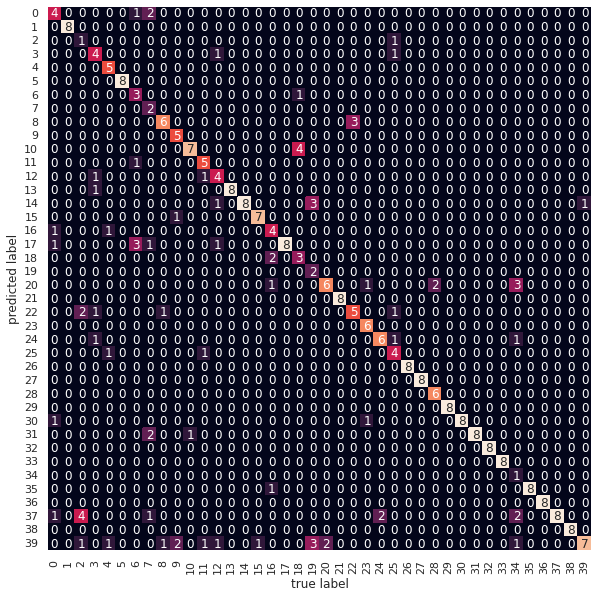

In [ ]:
lda = LDA(n_components=30)
lda.fit(x_train_1.reshape(-1, img_height*img_width), y_train_1)

gallery = lda.transform(x_train_1.reshape(-1, img_height*img_width))
probe = lda.transform(x_test_1.reshape(-1, img_height*img_width))

logr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logr.fit(gallery, y_train_1)
yfit = logr.predict(probe)

mat = confusion_matrix(y_test_1, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_1, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_1.shape[0], (y_test_1 != yfit).sum()))

Scenario 1 has an accuracy of 75%, similar to PCA's Scenario 1. The mistakes are more uniform throughout the set compared to PCA.

##Scenario 2: Use 50% of the images for training and 50% for testing.

Visualization of evaluation scenario 2: Use 50% of the images for training and 50% for testing.

Image Height * Width:  4096
Training Shape:  (200, 4096)
Testing Shape:  (200, 4096)
Projected Shape:  (200, 2)
Variance Ratio:  [0.18430357 0.12473496]
Average Image: 


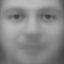

In [ ]:
lda = LDA(n_components=2)
projected = lda.fit_transform(x_train_2.reshape(-1, img_height*img_width), y_train_2)

print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_2.shape)
print("Testing Shape: ", x_test_2.shape)
print("Projected Shape: ", projected.shape)

print("Variance Ratio: ", lda.explained_variance_ratio_)
print("Average Image: ")

cv2_imshow(lda.xbar_.reshape(img_height, img_width) * 255)

LDA CMC Curve - Scenario 2 (50 / 50 Split):

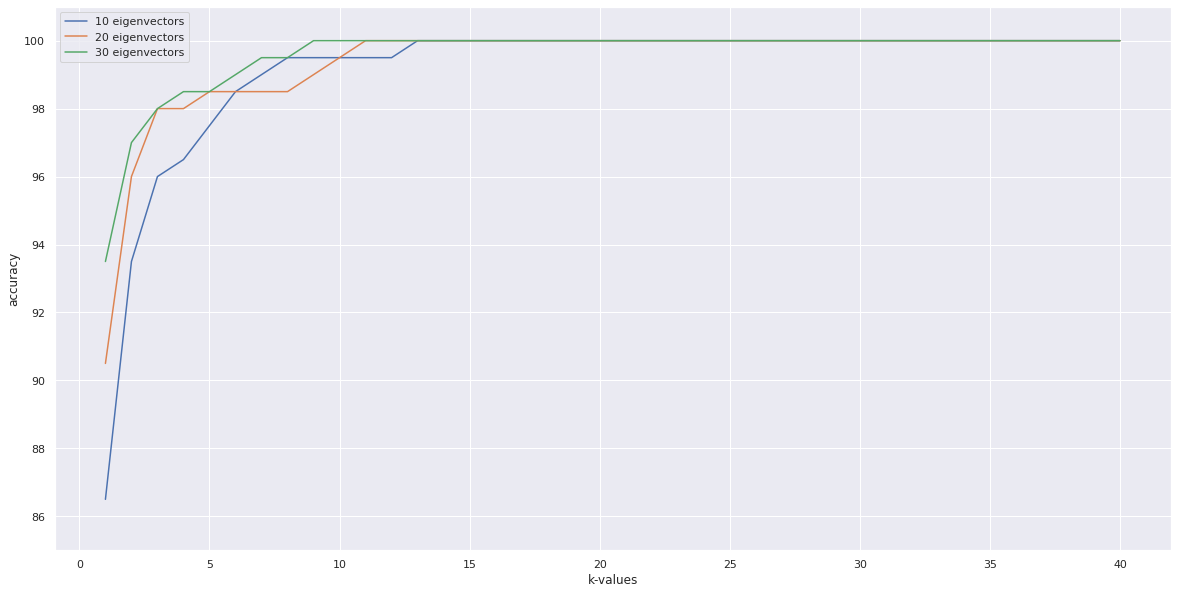

In [ ]:
# CMC plots for LDA
for i in range(10,40,10):
  lda = LDA(n_components=i)
  lda.fit(x_train_2.reshape(-1, img_height*img_width), y_train_2)

  gallery = lda.transform(x_train_2.reshape(-1, img_height*img_width))
  probe = lda.transform(x_test_2.reshape(-1, img_height*img_width))

  CMC = {}
  # For each test case...
  for j in range(len(probe)):
    # Compute the distance to closest correct label.
    genuine_dist = np.inf
    for k in range(len(gallery)):
      if y_test_2[j] == y_train_2[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          genuine_dist = dist
    # Compute number of incorrect labels closer than closest correct label.
    ids = set()
    for k in range(len(gallery)):
      if y_test_2[j] != y_train_2[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          ids.add(y_train_2[k])
    # Record rank of closest correct label.
    rank=1+len(ids)
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  rank = []
  acc = []
  total = 0
  for j in range(1, N_IDENTITIES+1):
    if j in CMC:
      total += CMC[j]
    rank.append(j)
    acc.append(100.0*total/len(probe))

  plt.plot(rank, acc, label=str(i)+' eigenvectors')
  plt.legend()
  plt.xlabel('k-values')
  plt.ylabel('accuracy')
  plt.ylim(85, 101)
  plt.plot()

LDA Confusion Matrix - Scenario 2 (50/50 Split):

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.57      0.80      0.67         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      0.20      0.33         5
          17       1.00    

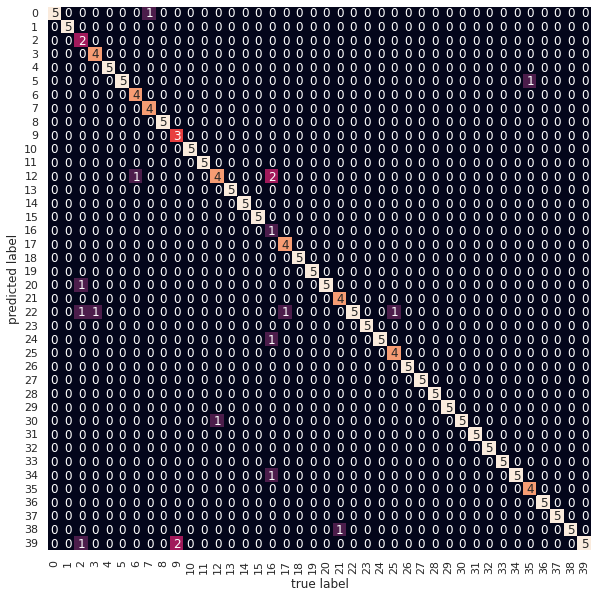

In [ ]:
lda = LDA(n_components=30)
lda.fit(x_train_2.reshape(-1, img_height*img_width), y_train_2)

gallery = lda.transform(x_train_2.reshape(-1, img_height*img_width))
probe = lda.transform(x_test_2.reshape(-1, img_height*img_width))

logr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logr.fit(gallery, y_train_2)
yfit = logr.predict(probe)

mat = confusion_matrix(y_test_2, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_2, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_2.shape[0], (y_test_2 != yfit).sum()))

Scenario 2 has an accuracy of 92%, which is 2% higher than PCA's Scenario 2. The model struggles to identify some of the middle pictures and some later ones.

##Scenario 3: Use 80% of the images for training and 20% for testing.

Visualization of evaluation scenario 3: Use 80% of the images for training and 20% for testing.

Image Height * Width:  4096
Training Shape:  (320, 4096)
Testing Shape:  (80, 4096)
Projected Shape:  (320, 2)
Variance Ratio:  [0.14880972 0.12554614]
Average Image: 


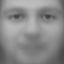

In [ ]:
lda = LDA(n_components=2)
projected = lda.fit_transform(x_train_3.reshape(-1, img_height*img_width), y_train_3)

print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_3.shape)
print("Testing Shape: ", x_test_3.shape)
print("Projected Shape: ", projected.shape)

print("Variance Ratio: ", lda.explained_variance_ratio_)
print("Average Image: ")

cv2_imshow(lda.xbar_.reshape(img_height, img_width) * 255)

LDA CMC Curve - Scenario 3 (80 / 20 Split):

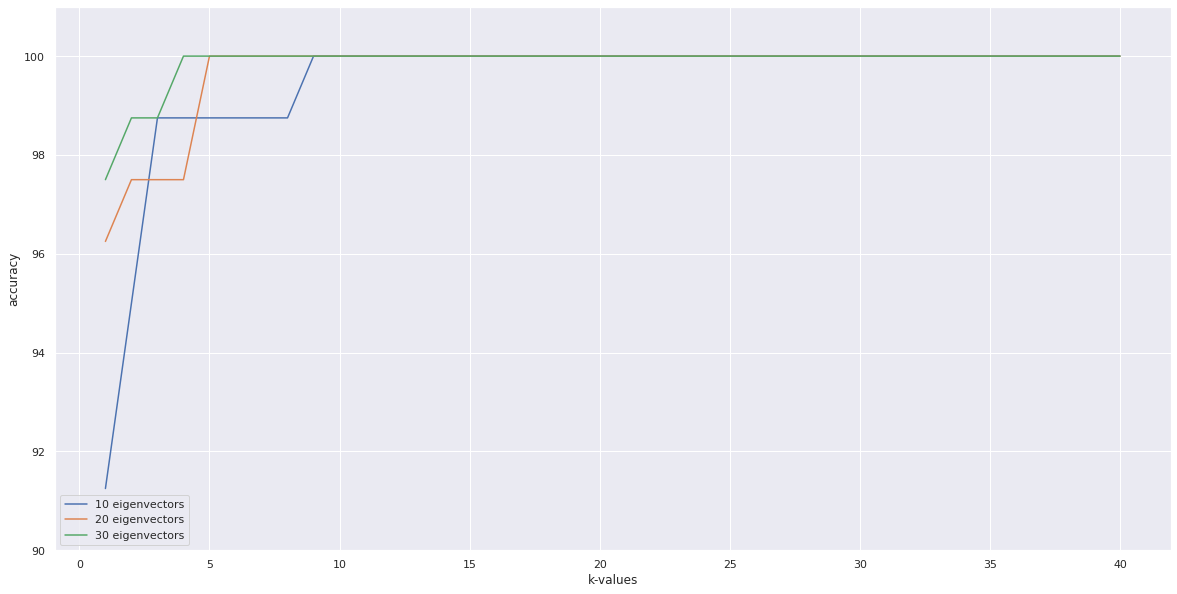

In [ ]:
# CMC plots for LDA
for i in range(10,40,10):
  lda = LDA(n_components=i)
  lda.fit(x_train_3.reshape(-1, img_height*img_width), y_train_3)

  gallery = lda.transform(x_train_3.reshape(-1, img_height*img_width))
  probe = lda.transform(x_test_3.reshape(-1, img_height*img_width))

  CMC = {}
  # For each test case...
  for j in range(len(probe)):
    # Compute the distance to closest correct label.
    genuine_dist = np.inf
    for k in range(len(gallery)):
      if y_test_3[j] == y_train_3[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          genuine_dist = dist
    # Compute number of incorrect labels closer than closest correct label.
    ids = set()
    for k in range(len(gallery)):
      if y_test_3[j] != y_train_3[k]:
        dist = np.sum((gallery[k]-probe[j])**2)
        if dist < genuine_dist:
          ids.add(y_train_3[k])
    # Record rank of closest correct label.
    rank=1+len(ids)
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  rank = []
  acc = []
  total = 0
  for j in range(1, N_IDENTITIES+1):
    if j in CMC:
      total += CMC[j]
    rank.append(j)
    acc.append(100.0*total/len(probe))

  plt.plot(rank, acc, label=str(i)+' eigenvectors')
  plt.legend()
  plt.xlabel('k-values')
  plt.ylabel('accuracy')
  plt.ylim(90, 101)
  plt.plot()

LDA Confusion Matrix - Scenario 3 (80/20 Split):

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

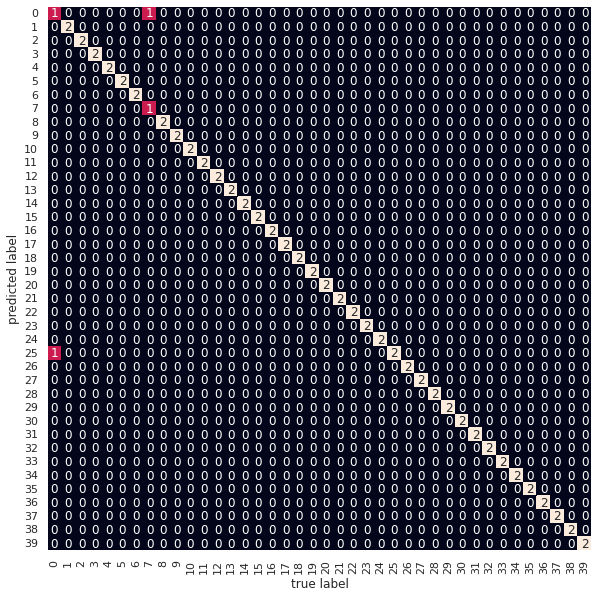

In [ ]:
lda = LDA(n_components=30)
lda.fit(x_train_3.reshape(-1, img_height*img_width), y_train_3)

gallery = lda.transform(x_train_3.reshape(-1, img_height*img_width))
probe = lda.transform(x_test_3.reshape(-1, img_height*img_width))

logr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
logr.fit(gallery, y_train_3)
yfit = logr.predict(probe)

mat = confusion_matrix(y_test_3, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

print(classification_report(y_test_3, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_3.shape[0], (y_test_3 != yfit).sum()))

Scenario 3's model is the most accurate we've seen so far from PCA and LDA alike. With an accuract of 97%, there are hardly any mistakes from LDA's 3rd model.

#Data for SVM:

##Scenario 1: Use 20% of the images for training and 80% for testing.

Visualization of evaluation scenario 1: Use 20% of the images for training and 80% for testing.

In [ ]:
model = SVC(kernel='linear')
model.fit(x_train_1, y_train_1)
yfit = model.predict(x_test_1)

print("Faces Shape: ", faces.images.shape)
print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_1.shape)
print("Testing Shape: ", x_test_1.shape)
print(faces.images.shape)


Faces Shape:  (400, 64, 64)
Image Height * Width:  4096
Training Shape:  (80, 4096)
Testing Shape:  (320, 4096)
(400, 64, 64)


SVM CMC Curve - Scenario 1 (20 / 80 Split):

In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train_1, y_train_1)

yfit = model.predict_proba(x_test_1)

In [ ]:
def plot_CMC(ysimilarity, ytarget):
  assert len(ysimilarity) == len(ytarget)
  CMC = {}
  for i in range(len(ysimilarity)):
    # get similarity for the correct class
    genuine_sim = ysimilarity[i][ytarget[i]]
    # count how many incorrect classes have higher similarity
    rank = 1
    for j, sim in enumerate(ysimilarity[i]):
      if j != ytarget[i]:
        if sim >= genuine_sim:
          rank += 1
    # save rank
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  # cumulative sum to create CMC
  N = []
  rankN = []
  total = 0
  for i in range(1,len(ysimilarity[0])+1):
    if i in CMC:
      total += CMC[i]
    N.append(i)
    rankN.append(100.0*total/len(ysimilarity))

  plt.plot(N, rankN)
  plt.xlabel('N')
  plt.ylabel('accuracy')
  plt.plot()

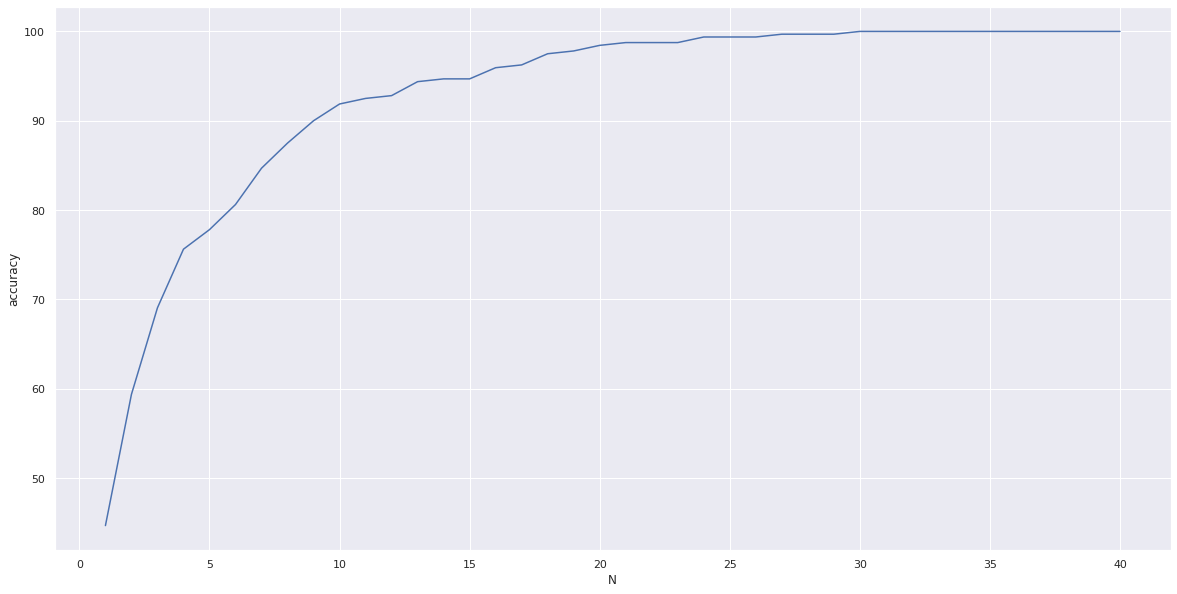

In [ ]:
plot_CMC(yfit, y_test_1)

The plot above shows SVC's accuracy as N increases.

SVM Confusion Matrix - Scenario 1 (20 / 80 Split):

              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       1.00      1.00      1.00         8
           2       0.20      0.12      0.15         8
           3       1.00      0.38      0.55         8
           4       0.50      0.88      0.64         8
           5       1.00      1.00      1.00         8
           6       0.83      0.62      0.71         8
           7       1.00      0.38      0.55         8
           8       0.71      0.62      0.67         8
           9       1.00      0.62      0.77         8
          10       0.67      1.00      0.80         8
          11       1.00      0.88      0.93         8
          12       1.00      0.38      0.55         8
          13       0.89      1.00      0.94         8
          14       0.42      1.00      0.59         8
          15       1.00      1.00      1.00         8
          16       1.00      0.38      0.55         8
          17       0.88    

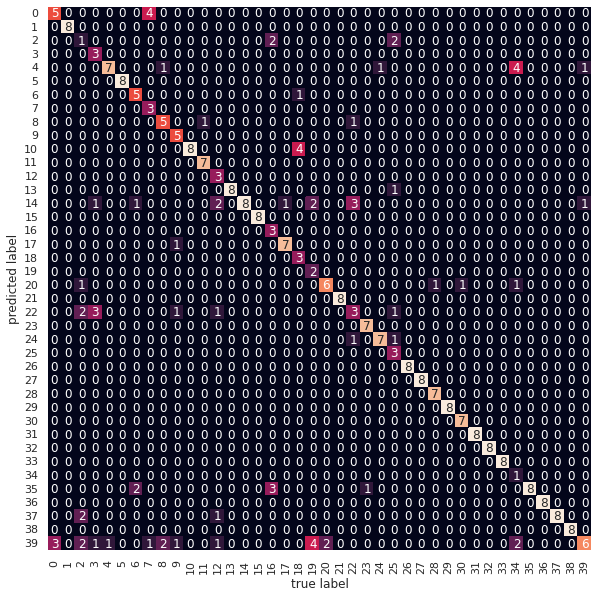

In [ ]:
yfit = model.predict(x_test_1)

mat = confusion_matrix(y_test_1, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test_1, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_1.shape[0], (y_test_1 != yfit).sum()))

Similar to PCA and LDA, Scenario 1 has an accuracy of 76%. It struggles pretty uniformly, doing slightly better towards the later images.

##Scenario 2: Use 50% of the images for training and 50% for testing.

Visualization of evaluation scenario 2: Use 50% of the images for training and 50% for testing.

In [ ]:
model = SVC(kernel='linear')
model.fit(x_train_2, y_train_2)
yfit = model.predict(x_test_2)

print("Faces Shape: ", faces.images.shape)
print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_2.shape)
print("Testing Shape: ", x_test_2.shape)

Faces Shape:  (400, 64, 64)
Image Height * Width:  4096
Training Shape:  (200, 4096)
Testing Shape:  (200, 4096)


SVM CMC Curve - Scenario 2 (50 / 50 Split):

In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train_2, y_train_2)

yfit = model.predict_proba(x_test_2)

In [ ]:
def plot_CMC(ysimilarity, ytarget):
  assert len(ysimilarity) == len(ytarget)
  CMC = {}
  for i in range(len(ysimilarity)):
    # get similarity for the correct class
    genuine_sim = ysimilarity[i][ytarget[i]]
    # count how many incorrect classes have higher similarity
    rank = 1
    for j, sim in enumerate(ysimilarity[i]):
      if j != ytarget[i]:
        if sim >= genuine_sim:
          rank += 1
    # save rank
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  # cumulative sum to create CMC
  N = []
  rankN = []
  total = 0
  for i in range(1,len(ysimilarity[0])+1):
    if i in CMC:
      total += CMC[i]
    N.append(i)
    rankN.append(100.0*total/len(ysimilarity))

  plt.plot(N, rankN)
  plt.xlabel('N')
  plt.ylabel('accuracy')
  plt.plot()

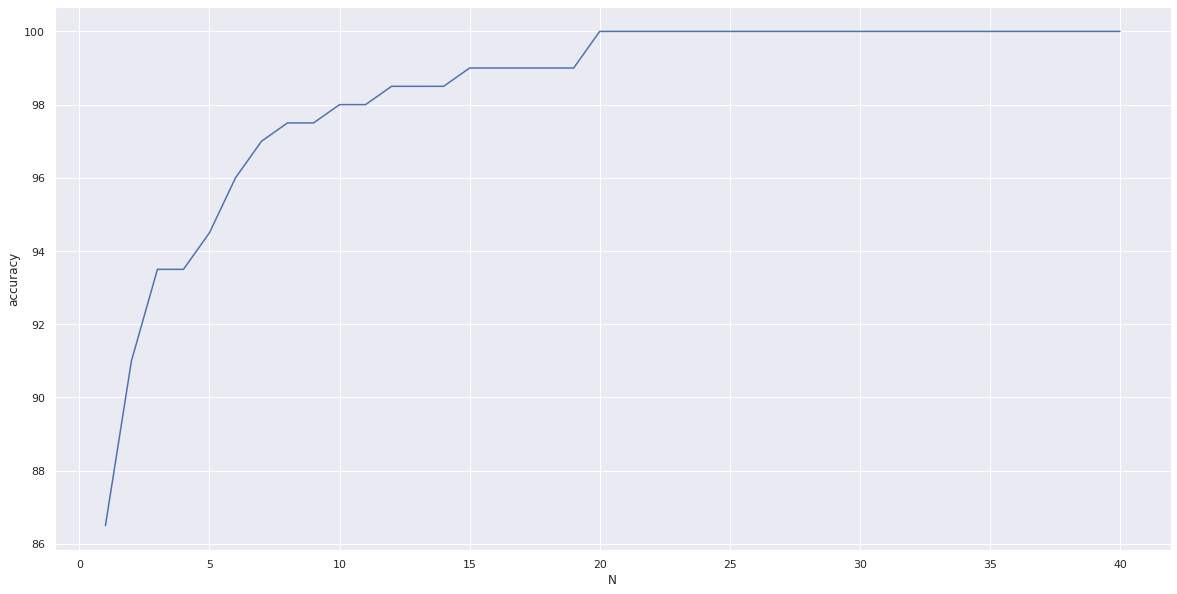

In [ ]:
plot_CMC(yfit, y_test_2)

The plot above shows SVC's accuracy as N increases.

SVM Confusion Matrix - Scenario 2 (50 / 50 Split):

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       0.80      0.80      0.80         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      0.20      0.33         5
          17       1.00    

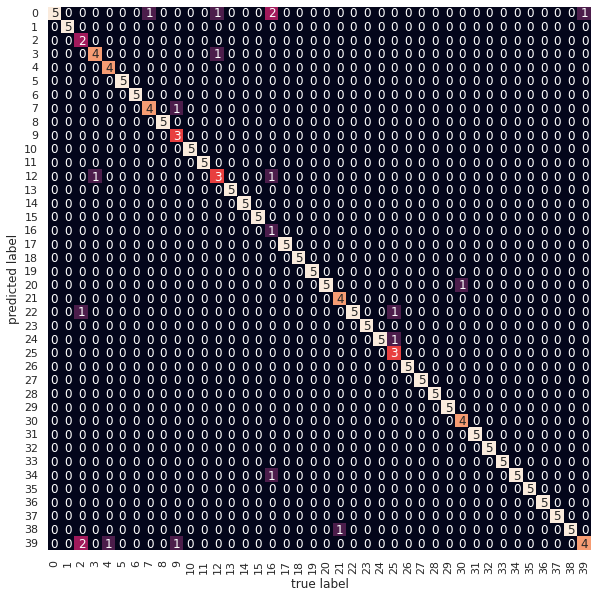

In [ ]:
yfit = model.predict(x_test_2)

mat = confusion_matrix(y_test_2, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test_2, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_2.shape[0], (y_test_2 != yfit).sum()))

Scenario 2 has an accuracy of 91%, which is much higher than Scenario 1, and about the same as LDA's Scenario 2.

##Scenario 3: Use 80% of the images for training and 20% for testing.

Visualization of evaluation scenario 3: Use 80% of the images for training and 20% for testing.

In [ ]:
model = SVC(kernel='linear')
model.fit(x_train_3, y_train_3)
yfit = model.predict(x_test_3)

print("Faces Shape: ", faces.images.shape)
print("Image Height * Width: ", img_height*img_width)
print("Training Shape: ", x_train_3.shape)
print("Testing Shape: ", x_test_3.shape)

Faces Shape:  (400, 64, 64)
Image Height * Width:  4096
Training Shape:  (320, 4096)
Testing Shape:  (80, 4096)


SVM CMC Curve - Scenario 3 (80 / 20 Split):

In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train_3, y_train_3)

yfit = model.predict_proba(x_test_3)

In [ ]:
def plot_CMC(ysimilarity, ytarget):
  assert len(ysimilarity) == len(ytarget)
  CMC = {}
  for i in range(len(ysimilarity)):
    # get similarity for the correct class
    genuine_sim = ysimilarity[i][ytarget[i]]
    # count how many incorrect classes have higher similarity
    rank = 1
    for j, sim in enumerate(ysimilarity[i]):
      if j != ytarget[i]:
        if sim >= genuine_sim:
          rank += 1
    # save rank
    if rank not in CMC:
      CMC[rank] = 1
    else:
      CMC[rank] += 1

  # cumulative sum to create CMC
  N = []
  rankN = []
  total = 0
  for i in range(1,len(ysimilarity[0])+1):
    if i in CMC:
      total += CMC[i]
    N.append(i)
    rankN.append(100.0*total/len(ysimilarity))

  plt.plot(N, rankN)
  plt.xlabel('N')
  plt.ylabel('accuracy')
  plt.plot()

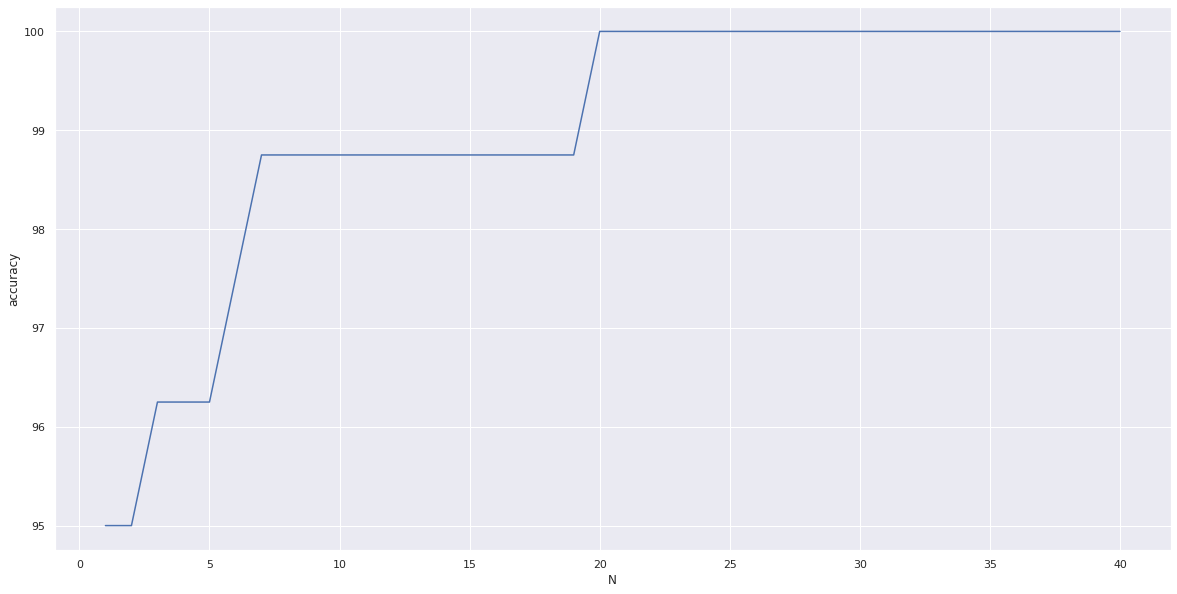

In [ ]:
plot_CMC(yfit, y_test_3)

The plot above shows SVC's accuracy as N increases.

SVM Confusion Matrix - Scenario 3 (80 / 20 Split):

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

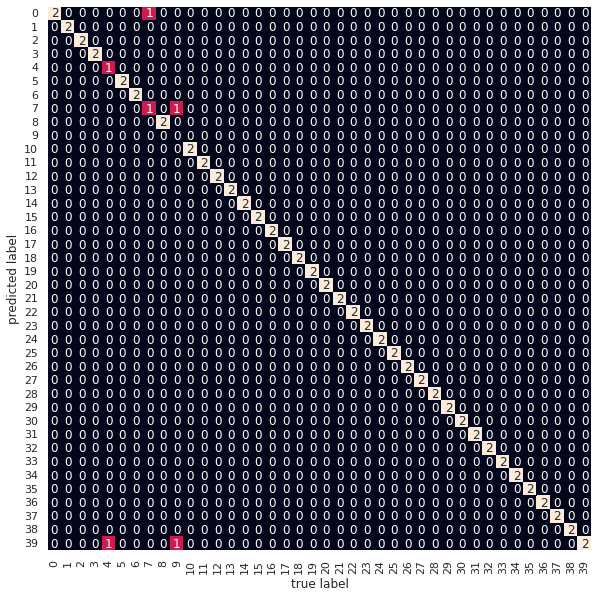

In [ ]:
yfit = model.predict(x_test_3)

mat = confusion_matrix(y_test_3, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test_3, yfit))
print("Number of mislabeled points out of total %d points: %d" % (x_test_3.shape[0], (y_test_3 != yfit).sum()))

Scenario 3 has an accuracy of 95%, which is slightly higher than Scenario 2, but a bit lower than Scenario 3 from LDA's model. This model struggles somewhat early on and again on the final image.

# Results



##Small CNN Analysis:





Accuracy:

*   Scenario 1: ~63%
*   Scenario 2: ~80%
*   Scenario 3: ~81%



##PCA Analysis:

Accuracy:

*   Scenario 1: ~75%
*   Scenario 2: ~91%
*   Scenario 3: ~94%



PCA performs much better than Small CNN.

##LDA Analysis:

Accuracy:

*   Scenario 1: ~75%
*   Scenario 2: ~92%
*   Scenario 3: ~97%

LDA performs the same as PCA in scenario 1. It performs slightly better than PCA in scenario 2 and 3.

##SVM Analysis:

Accuracy:

*   Scenario 1: ~76%
*   Scenario 2: ~91%
*   Scenario 3: ~95%

SVM performs very similarly to PCA. It is slightly better in every scenario, but overall worse than LDA.

##Overall Analysis:

It is clear that all the algorithms used surpass the Small CNN (LeNet-5) in every aspect. With the proper amount of training data, PCA, LDA, and SVM are all fairly sufficient for facial recognition. Data augmentation of LeNet-5 made very little difference (although re-runs may differ). Certain augmentations may make it better, but in this case it was pointless.

---
SVM performed similar to PCA in every aspect, scoring around 1% than PCA higher across all scenarios. LDA performed best overall, scoring the highest accuracy of 97% in scenario 3, and 92% in scenario 2.

---

It is important to note however, that the dataset is not very large. In the case of scenario 3, only testing on 2 images can lead to misleading results if the data was scaled to a much larger size. It is hard to tell whether the algorithms would perform better or worse given a larger dataset, as the set we have to analyze is so small. It is significant though that through every scenario, the data has grown more accurate as the training size has increased.

---
LDA is the superior choice when it comes to facial recognition in this experiment.


# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [ ]:
import tensorflow_datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.losses import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns; sns.set()

Load dataset

In [ ]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [ ]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(2000):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

Visualize and Vectorize Data:

In [ ]:
max_words = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_words)
vectorize_layer.adapt(x_train)

In [ ]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'but', 'movie',
       'film', 'on', 'you', 'not', 'are', 'his', 'have', 'be', 'he',
       'one', 'at', 'its', 'all', 'they', 'by', 'an', 'so', 'who', 'her',
       'like', 'from', 'just', 'if', 'or', 'out', 'about', 'has', 'what',
       'some', 'good', 'there', 'very', 'when', 'more', 'my', 'no', 'she',
       'even', 'up', 'which', 'time', 'had', 'would', 'really', 'me',
       'only', 'can', 'were', 'see', 'story', 'their', 'than', 'get',
       'much', 'great', 'into', 'do', 'first', 'because', 'we', 'been',
       'will', 'well', 'bad', 'other', 'also', 'most', 'dont', 'how',
       'him', 'too', 'films', 'then', 'made', 'people', 'way', 'movies',
       'make', 'them', 'could'], dtype='<U14')

In [ ]:
print(x_train[:2])
vectorized = vectorize_layer(x_train[:2]).numpy()
print(vectorized)

[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development w

#Baseline - Basic Binary Classification Model 

Create Model:

In [ ]:
embedding_dim = 16
model = tf.keras.Sequential([
    vectorize_layer,
  tf.keras.layers.Embedding(max_words + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          16016     
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

Loss function and Optimizer:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Train Model:

In [ ]:
history = model.fit(x=x_train, y=y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
63/63 [==============================] - 2s 13ms/step - loss: 0.6929 - binary_accuracy: 0.5300 - val_loss: 0.6924 - val_binary_accuracy: 0.5725
Epoch 2/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6918 - binary_accuracy: 0.5440 - val_loss: 0.6914 - val_binary_accuracy: 0.5710
Epoch 3/10
63/63 [==============================] - 1s 10ms/step - loss: 0.6906 - binary_accuracy: 0.6120 - val_loss: 0.6904 - val_binary_accuracy: 0.6950
Epoch 4/10
63/63 [==============================] - 1s 10ms/step - loss: 0.6891 - binary_accuracy: 0.6335 - val_loss: 0.6890 - val_binary_accuracy: 0.6965
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 0.6875 - binary_accuracy: 0.6340 - val_loss: 0.6872 - val_binary_accuracy: 0.6735
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 0.6848 - binary_accuracy: 0.6440 - val_loss: 0.6849 - val_binary_accuracy: 0.6660
Epoch 7/10
63/63 [==============================] - 1s 9ms/step - loss: 

Evaluate Model:

In [ ]:
loss, accuracy = model.evaluate(x=x_train, y=y_train)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

63/63 [==============================] - 0s 4ms/step - loss: 0.6670 - binary_accuracy: 0.7375
Loss:  0.6670067310333252
Accuracy:  0.737500011920929


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

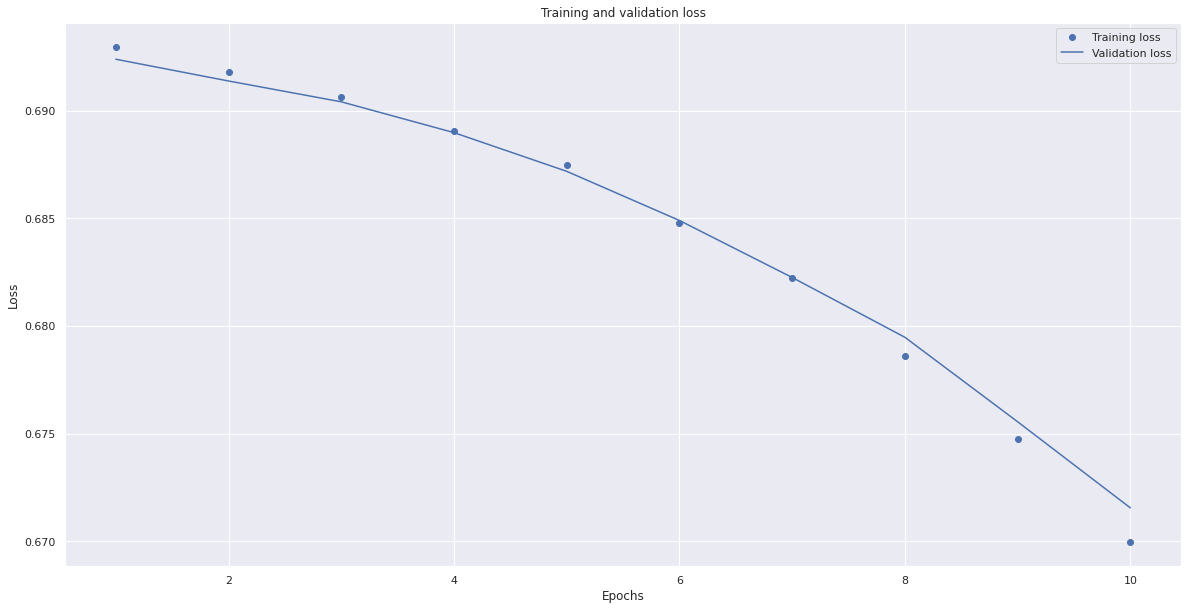

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

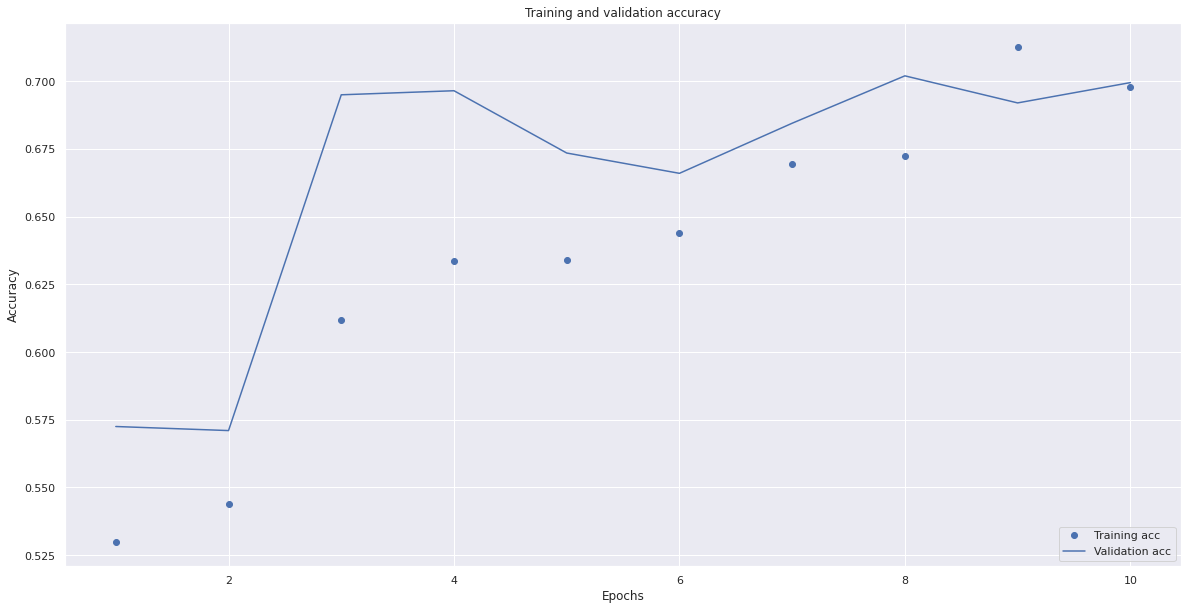

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Confusion Matrix:

63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       980
           1       0.00      0.00      0.00      1020

    accuracy                           0.49      2000
   macro avg       0.24      0.50      0.33      2000
weighted avg       0.24      0.49      0.32      2000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


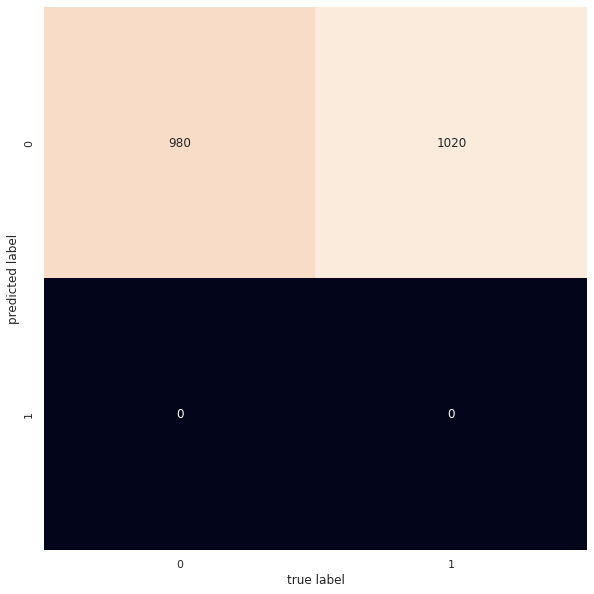

In [ ]:
#Normalize Prediction
def normalize_pred(predictions):
  for i in range(len(predictions)):
    if predictions[i]>=0.5:
      predictions[i]=1
    elif predictions[i]<0.5:
      predictions[i]=0
  return predictions

#Graph Model
yfit = model.predict(x_test)
yfit = normalize_pred(yfit)

mat = confusion_matrix(y_test, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test, yfit))

#Vanilla RNN Model

Create Model:

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Train Model:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
32/32 [==============================] - 42s 1s/step - loss: 0.6945 - accuracy: 0.4905 - val_loss: 0.6925 - val_accuracy: 0.5120
Epoch 2/10
32/32 [==============================] - 41s 1s/step - loss: 0.6876 - accuracy: 0.5530 - val_loss: 0.6924 - val_accuracy: 0.5115
Epoch 3/10
32/32 [==============================] - 42s 1s/step - loss: 0.6805 - accuracy: 0.6095 - val_loss: 0.6917 - val_accuracy: 0.5175
Epoch 4/10
32/32 [==============================] - 42s 1s/step - loss: 0.6718 - accuracy: 0.6455 - val_loss: 0.6878 - val_accuracy: 0.5480
Epoch 5/10
32/32 [==============================] - 41s 1s/step - loss: 0.6596 - accuracy: 0.6810 - val_loss: 0.6984 - val_accuracy: 0.5125
Epoch 6/10
32/32 [==============================] - 45s 1s/step - loss: 0.6504 - accuracy: 0.6790 - val_loss: 0.6784 - val_accuracy: 0.5810
Epoch 7/10
32/32 [==============================] - 42s 1s/step - loss: 0.6208 - accuracy: 0.7210 - val_loss: 0.6543 - val_accuracy: 0.6200
Epoch 8/10
32/32 [==

Evaluate Model:

In [ ]:
loss, accuracy = model.evaluate(x=x_train, y=y_train)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

63/63 [==============================] - 5s 79ms/step - loss: 0.4529 - accuracy: 0.8440
Loss:  0.45291852951049805
Accuracy:  0.843999981880188


(0.0, 0.7090078353881836)

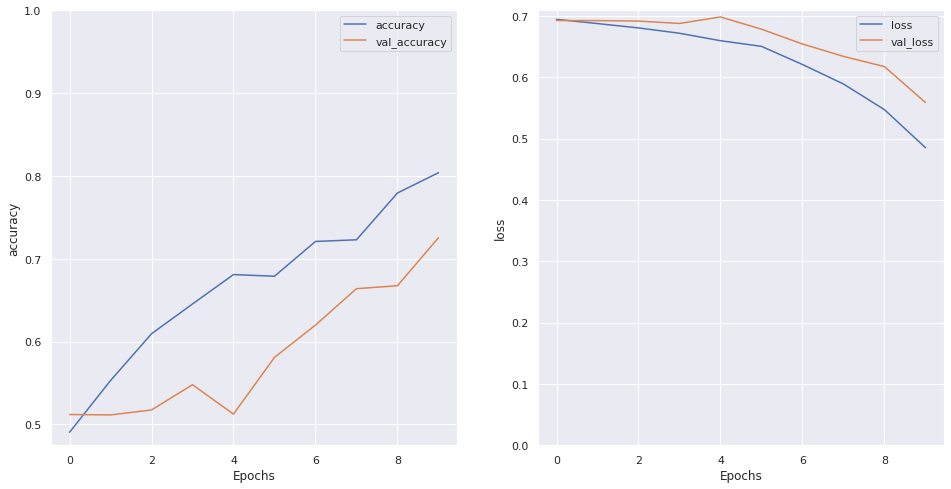

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Confusion Matrix:

63/63 [==============================] - 5s 78ms/step
              precision    recall  f1-score   support

           0       0.76      0.64      0.69       980
           1       0.70      0.81      0.75      1020

    accuracy                           0.73      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.73      0.72      2000



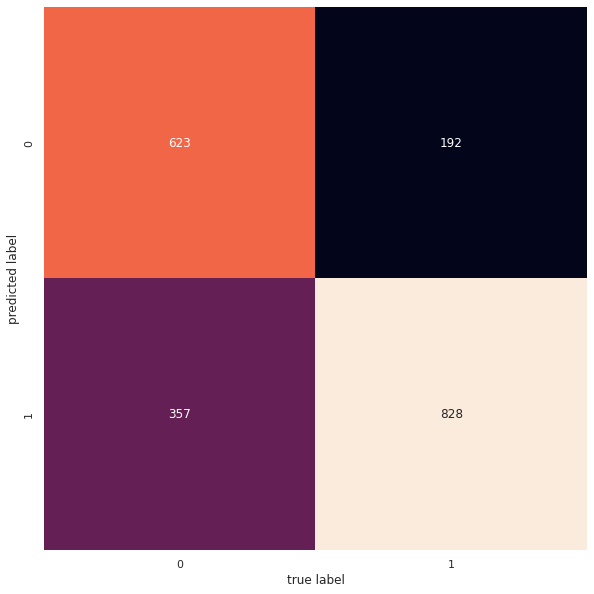

In [ ]:
#Normalize Prediction
def normalize_pred(predictions):
  for i in range(len(predictions)):
    if predictions[i]>=0.5:
      predictions[i]=1
    elif predictions[i]<0.5:
      predictions[i]=0
  return predictions

#Graph Model
yfit = model.predict(x_test)
yfit = normalize_pred(yfit)

mat = confusion_matrix(y_test, yfit)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
print(classification_report(y_test, yfit))

#Analysis:

Vanilla RNN sports an accuracy of 84% while the baseline model has an accuracy of 73% (Percentages may vary based on runtime and training variations. Accuracy will also differ whether you're looking at the command or the confusion tables.) Either way, it is clear that RNN is much more accurate than the baseline.



RNN is very sensitive to hyper-parameters and augmentations as well. Similar to LeNet-5, augmentations that aren't done carefully will lead to a drop in overall performance.